In [101]:
import nibabel as nib
import nilearn
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
import re
import os
import numpy as np
import pandas as pd
import pickle as pkl
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import multiprocessing as mp
from functools import partial
import itertools
import copy
import time
from utils import apply_warp

%matplotlib inline

## Model specifications

### model 0a:
- SAT on cue
- On feedback: RPE (z-scored)
- On stimulus: Value diff (z-scored)

### model 1:
- Contrast-coded events
- On feedback: RPE (z-demeaned)
- On stimulus: Value diff (z-demeaned)

In [95]:
def merge_events_regressors(events, regressors, 
                            on_stimulus=('value_chosen', 'value_unchosen', 'value_high', 'value_low', 'outcome', 'value_difference'),
                            on_feedback=('value_chosen', 'outcome'),
                            zscore=(),
                            demean=()):
    ''' merge 'events' df (with onsets trial types) with trial-wise 'regressors' df, which contains the covariates '''
    ''' what to do with demeaning'''
    
    if 'rt' in on_stimulus:
        # extract response time from events, add to trial-wise regressors
        tmp = events.pivot_table(values='onset', index='trial_nr', columns='trial_type')
        tmp['response_onset'] = tmp[['response_left', 'response_right']].apply(lambda x: np.nansum(x), axis=1)
        tmp.loc[(pd.isnull(tmp.response_left) & pd.isnull(tmp.response_right)), 'response_onset'] = np.nan
        tmp['rt'] = tmp['response_onset'] - tmp['stimulus']
        regressors = pd.merge(regressors, tmp.reset_index()[['trial_nr', 'rt']], how='outer')
    if 'value_difference' in on_stimulus:
        regressors['value_difference'] = regressors['Q_value_difference'] #regressors['SR.r2'] - regressors['SR.r1']

    # z-score regressors that need to be z-scored
    if len(zscore)>0:
        for regressor_name in zscore:
            regressors[[regressor_name]] = regressors[[regressor_name]].apply(lambda x: (x-x.mean())/x.std())
    
    if len(demean)>0:
        for regressor_name in demean:
            regressors[[regressor_name]] = regressors[[regressor_name]].apply(lambda x: (x-x.mean()))

    ## 
    if len(on_stimulus) > 0:
        regressors_on_stimulus = regressors.melt(id_vars='trial_nr', 
                                                 value_vars=on_stimulus).rename(columns={'variable':'trial_type', 'value': 'modulation'})
        regressors_on_stimulus['trial_type2'] = 'stimulus'
    
    if len(on_feedback) > 0:
        regressors_on_feedback = regressors.melt(id_vars='trial_nr', 
                                                 value_vars=on_feedback).rename(columns={'variable':'trial_type', 'value': 'modulation'})
        regressors_on_feedback['trial_type2'] = 'feedback'


    # merge with events
    to_concat = [events]
    if len(on_stimulus) > 0:
        tmp_stimulus_regressors = pd.merge(events, regressors_on_stimulus, left_on=['trial_nr', 'trial_type'], right_on=['trial_nr', 'trial_type2']).rename(columns={'trial_type_y':'trial_type'})
        tmp_stimulus_regressors['trial_type'] = tmp_stimulus_regressors['trial_type'].apply(lambda x: 'stimulus_'+x)
        to_concat.append(tmp_stimulus_regressors[['trial_nr', 'onset', 'trial_type', 'duration', 'modulation']])
    if len(on_feedback) > 0:
        tmp_feedback_regressors = pd.merge(events, regressors_on_feedback, left_on=['trial_nr', 'trial_type'], right_on=['trial_nr', 'trial_type2']).rename(columns={'trial_type_y':'trial_type'})
        tmp_feedback_regressors['trial_type'] = tmp_feedback_regressors['trial_type'].apply(lambda x: 'feedback_'+x)
        to_concat.append(tmp_feedback_regressors[['trial_nr', 'onset', 'trial_type', 'duration', 'modulation']])
    
    # Merge
    events = pd.concat(to_concat, 0).sort_values('onset').reset_index(drop=True)
    
#    print(events)
    
    events['duration'] = 0.001
    events = events.loc[~(events.trial_type.isin(list(on_stimulus)+list(on_feedback)) & pd.isnull(events.modulation))]    
    events['modulation'] = events['modulation'].fillna(1)
    return events

def make_contrast_matrix(events, demean_contrasts=True):
    events.loc[events.trial_type == 'cue_SPD', 'modulation'] = 1
    events.loc[events.trial_type == 'cue_ACC', 'modulation'] = -1
    events.loc[events.trial_type.isin(['cue_SPD', 'cue_ACC']), 'trial_type'] = 'cue_SPDminACC'
    if demean_contrasts:
        idx = events.trial_type == 'cue_SPDminACC'
        events.loc[idx, 'modulation'] = events.loc[idx, 'modulation']-events.loc[idx, 'modulation'].mean()
    tmp = events.loc[events.trial_type == 'cue_SPDminACC'].copy()
    tmp['trial_type'] = 'cue'
    tmp['modulation'] = 1
    events = pd.concat([events, tmp]).sort_values(['onset'])

    #
    events.loc[events.trial_type == 'response_left', 'modulation'] = 1
    events.loc[events.trial_type == 'response_right', 'modulation'] = -1
    events.loc[events.trial_type.isin(['response_left', 'response_right']), 'trial_type'] = 'response_leftminright'
    if demean_contrasts:
        idx = events.trial_type == 'response_leftminright'
        events.loc[idx, 'modulation'] = events.loc[idx, 'modulation']-events.loc[idx, 'modulation'].mean()
    tmp = events.loc[events.trial_type == 'response_leftminright'].copy()
    tmp['trial_type'] = 'response'
    tmp['modulation'] = 1
    events = pd.concat([events, tmp]).sort_values(['onset'])

    events.loc[events.trial_type.isin(['cue', 'stimulus', 'response', 'feedback']), 'trial_type'] = 'cuestimrespfeedback'
    return events


def make_events_this_model(events, regressors, model_n):
    ### Create events corresponding to this model's design matrix
    
    if model_n == '0a':
        on_stimulus=('value_difference',)
        on_feedback=('PE',)
        zscore = ()
        demean = ()
    elif model_n == '0a-z':
        on_stimulus=('value_difference',)
        on_feedback=('PE',)
        zscore = ('value_difference', 'PE')
        demean = ()
    elif model_n == '1-dm':
        on_stimulus=('value_difference',)
        on_feedback=('PE',)
        demean = ('value_difference', 'PE')
        zscore = ()
    elif model_n == '1-z':
        on_stimulus=('value_difference',)
        on_feedback=('PE',)
        zscore = ('value_difference', 'PE')
        demean = ()

    events = merge_events_regressors(events, regressors, on_stimulus=on_stimulus, on_feedback=on_feedback, zscore=zscore, demean=demean)[['onset', 'trial_type', 'duration', 'modulation']]
    
    return events

In [90]:
# sub = '009'
# ses = 'rlsat'
# task = 'rlsat'
# model_n='0a-dm'
# event_fns = sorted(glob.glob(f'../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_events.tsv'))
# regressor_fns = sorted(glob.glob(f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_desc-model-regressors.tsv'))
# events = pd.read_csv(event_fns[0], sep='\t', index_col=None)  # Onsets & event types
# regressors  = pd.read_csv(regressor_fns[0], sep='\t')         # Trial-by-trial covariates
# events = make_events_this_model(events, regressors, model_n)
# events['modulation'] = events['modulation'].fillna(1)
# events = make_contrast_matrix(events)#.iloc[0:20]
# display(events.loc[events.trial_type.isin(['cuestimrespfeedback', 'response_leftminright'])])

# display(events.groupby(['trial_type'])['modulation'].mean().round(3))

In [96]:
def make_first_level_model_fn(sub, ses, task, smoothing_fwhm, model_n, space, save_dir_name='../derivatives/glm_nilearn/subject_level_model'):
    smoothing_fwhm = str(smoothing_fwhm).replace('.', 'p')
    return os.path.join(save_dir_name, f'sub-{sub}/ses-{ses}/func/fwhm-{smoothing_fwhm}/model-{model_n}/sub-{sub}_ses-{ses}_task-{task}_space-{space}_desc-first-level-model.pkl')


## load
def load_first_level_model(fn):
    if os.path.exists(fn):
        with open(fn, 'rb') as f:
            first_level_model = pkl.load(f)  # protocol=4 required due to size of pkl
        return first_level_model
    else:
        print(f'{fn} does not exist...')
        return 0
    
def fit_first_level_model(sub, ses, task, model_n=0, space='MNI152NLin2009cAsym', include_physio=True, n_jobs=20, smoothing_fwhm=4.5, 
                          use_susan_presmoothed_data=True,
                          save_model=True, save_dir_name='subject_level_model',
                          overwrite=False, return_model=True,
                          exclude_runs=None):
    # check for existing model
    smoothing_fwhm_str = str(smoothing_fwhm).replace('.', 'p')
    save_fn = make_first_level_model_fn(sub, ses, task, smoothing_fwhm, model_n, space, save_dir_name) # f'../derivatives/{save_dir_name}/sub-{sub}/ses-{ses}/func/fwhm-{smoothing_fwhm_str}/model-{model_n}/sub-{sub}_ses-{ses}_task-{task}_space-{space}_desc-first-level-model.pkl'
    if os.path.exists(save_fn) and not overwrite:
        print('Model already fit! Returning pre-fit model...')
        if return_model:
            return load_first_level_model(save_fn)
        else:
            return 0
    
    event_fns = sorted(glob.glob(f'../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_events.tsv'))
    regressor_fns = sorted(glob.glob(f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_desc-model-regressors-emc2.tsv'))
    confounds_fns = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_desc-confounds_timeseries.tsv'))
    
    # fix this for susan presmoothed data
    if use_susan_presmoothed_data:
        smoothing_fwhm = None
        func_fns = sorted(glob.glob(f'../derivatives/susan_smoothed_func/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_space-{space}_desc-preproc_bold_smoothed_fwhm-{smoothing_fwhm_str}.nii.gz'))
    else:
        func_fns = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_space-{space}_desc-preproc_bold.nii.gz'))
        
    # exclude some runs?
    if exclude_runs is not None:
        for run in exclude_runs:
            event_fns = [x for x in event_fns if not f'run-{run}' in x]
            regressor_fns = [x for x in regressor_fns if not f'run-{run}' in x]
            confounds_fns = [x for x in confounds_fns if not f'run-{run}' in x]
            func_fns = [x for x in func_fns if not f'run-{run}' in x]
    # print(sub)
#     print(event_fns)
    
    run_flms = []
    run_events = []
    run_funcs = []
    run_confounds = []

    for run, (event_fn, regressor_fn, func_fn, confounds_fn) in enumerate(zip(event_fns, regressor_fns, func_fns, confounds_fns)):    
        # Merge events with trial-by-trial regressors
        events = pd.read_csv(event_fn, sep='\t', index_col=None)  # Onsets & event types
        regressors  = pd.read_csv(regressor_fn, sep='\t')         # Trial-by-trial covariates
        
#         events = make_model_events(events, model_n)
        
#         if task == 'revl':
#             events = events.loc[~events.trial_type.isin(['cue'])]  # remove cue
#         events = merge_events_regressors(events, regressors, zscore=zscore, use_diff=use_diff)[['onset', 'trial_type', 'duration', 'modulation']]
        
        events = make_events_this_model(events, regressors, model_n)
        events = make_contrast_matrix(events)  #.iloc[0:20]
        run_events.append(events)

        # load func
        func = nib.load(func_fn)
        run_funcs.append(func)

        # get confounds
        confounds = pd.read_csv(confounds_fn, sep='\t')[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement']].fillna(method='bfill')

        # get retroicor
        if include_physio:
            run_idx = run+1
            retroicor_fn = f'../derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run_idx}_desc-retroicor_regressors.tsv'
            if not os.path.exists(retroicor_fn):
                ## take first 20 aCompCor components
                print("No retroicor found, including 20 a_comp_cor components")
                a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
                confounds = pd.concat([confounds, a_comp_cor], axis=1)
            else:
                retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
                retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
                confounds = pd.concat([confounds, retroicor], axis=1)

        run_confounds.append(confounds)
    
#     print(run_events)
    
    # get brain mask
    brain_mask = f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-1_space-{space}_desc-brain_mask.nii.gz'
    
    # wait a bit
    wait_time = (int(sub)-2)%15 * 5
    time.sleep(wait_time)
    
    # fit
    flm = FirstLevelModel(t_r=1.38, hrf_model = 'glover + derivative', slice_time_ref=0.5,
                          mask_img=brain_mask, smoothing_fwhm=smoothing_fwhm, 
                          n_jobs=n_jobs, subject_label=sub)
    flm_fitted = flm.fit(run_funcs, events=run_events, confounds=run_confounds)
    
    # save
    if save_model:
        print('saving model to {}'.format(save_fn))
        os.makedirs(os.path.dirname(save_fn), exist_ok=True)
        with open(save_fn, 'wb') as f:
            pkl.dump(flm_fitted, f, protocol=4)  # protocol=4 required due to size of pkl
    
    if return_model:
        return flm_fitted
    else:
        return 0

## Which participants do we have so far?

In [97]:
reg = re.compile('.*sub-(?P<sub>\d+)_ses-rlsat_task-rlsat_run-(?P<run>\d).*')

all_func_files = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses-rlsat/func/sub-*_ses-rlsat_task-rlsat_run-*_space-T1w_desc-preproc_bold.nii.gz'))
func_file_df = pd.DataFrame([{**reg.match(x).groupdict(), **{'Func file': True}} for x in all_func_files])

all_smoothed_func_files = sorted(glob.glob('../derivatives/susan_smoothed_func/sub-*/ses-rlsat/func/*'))
susan_file_df = pd.DataFrame([{**reg.match(x).groupdict(), **{'Susan smoothed': True}} for x in all_smoothed_func_files])

all_retroicor_files = sorted(glob.glob('../derivatives/retroicor/sub-*/ses-rlsat/func/sub-*_ses-rlsat_task-rlsat_run-*_desc-retroicor_regressors.tsv'))
retroicor_file_df = pd.DataFrame([{**reg.match(x).groupdict(), **{'Retroicor': True}} for x in all_retroicor_files])

all_event_files = sorted(glob.glob('../derivatives/event_files/sub-*/ses-rlsat/func/sub-*_ses-rlsat_task-rlsat_run-*_events.tsv'))
event_file_df = pd.DataFrame([{**reg.match(x).groupdict(), **{'Events': True}} for x in all_event_files])

all_behavior_files = sorted(glob.glob('../derivatives/behavior/sub-*/ses-rlsat/func/sub-*_ses-rlsat_task-rlsat*-emc2*'))
behav_file_df = pd.DataFrame([{**reg.match(x).groupdict(), **{'Behavior model': True}} for x in all_behavior_files])

combined_df = pd.merge(pd.merge(pd.merge(pd.merge(func_file_df, susan_file_df, on=['sub', 'run'], how='outer'), retroicor_file_df,on=['sub', 'run'], how='outer'), event_file_df, on=['sub', 'run'], how='outer'), behav_file_df, on=['sub', 'run'], how='outer')
combined_df = combined_df.set_index(['sub', 'run']).fillna(False)
combined_df['Complete'] = combined_df.apply(np.sum, axis=1) == 5

with pd.option_context('display.max_rows', 10000):
    display(combined_df.sort_index())

Func file  Susan smoothed  Retroicor  Events  Behavior model  \
sub run                                                                 
002 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
003 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
004 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
005 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
006 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
007 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
008 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
009 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
010 1         True            True       True    True            True   
    2         True            True      False    True            True   
    3         True            True      False    True            True   
011 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
012 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
013 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
014 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
015 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
016 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
017 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True       True    True            True   
018 1         True            True       True    True            True   
    2         True            True       True    True            True   
    3         True            True      False    True            True   
019 1         True            True       True    True            True   
    2         True            True       True    True            Tr

In [98]:
to_fit = [(x, 'rlsat', 'rlsat') for x in combined_df.reset_index()['sub'].unique()]
# to_fit = [x for x in to_fit if x[0] != '033']
# to_fit = [(x[0],x[1],x[2],[2]) if x[0] == '009' else (x[0],x[1],x[2],None) for x in to_fit]   # exclude run 2 for sub 9
to_fit = [(x[0],x[1],x[2],None) for x in to_fit]   # exclude run 2 for sub 9
to_fit

[('002', 'rlsat', 'rlsat', None),
 ('003', 'rlsat', 'rlsat', None),
 ('004', 'rlsat', 'rlsat', None),
 ('005', 'rlsat', 'rlsat', None),
 ('006', 'rlsat', 'rlsat', None),
 ('007', 'rlsat', 'rlsat', None),
 ('008', 'rlsat', 'rlsat', None),
 ('009', 'rlsat', 'rlsat', None),
 ('010', 'rlsat', 'rlsat', None),
 ('011', 'rlsat', 'rlsat', None),
 ('012', 'rlsat', 'rlsat', None),
 ('013', 'rlsat', 'rlsat', None),
 ('014', 'rlsat', 'rlsat', None),
 ('015', 'rlsat', 'rlsat', None),
 ('016', 'rlsat', 'rlsat', None),
 ('017', 'rlsat', 'rlsat', None),
 ('018', 'rlsat', 'rlsat', None),
 ('019', 'rlsat', 'rlsat', None),
 ('020', 'rlsat', 'rlsat', None),
 ('023', 'rlsat', 'rlsat', None),
 ('024', 'rlsat', 'rlsat', None),
 ('026', 'rlsat', 'rlsat', None),
 ('029', 'rlsat', 'rlsat', None),
 ('030', 'rlsat', 'rlsat', None),
 ('031', 'rlsat', 'rlsat', None),
 ('032', 'rlsat', 'rlsat', None),
 ('033', 'rlsat', 'rlsat', None),
 ('034', 'rlsat', 'rlsat', None),
 ('035', 'rlsat', 'rlsat', None),
 ('036', 'rlsa

## Fit

In [99]:
# for sub,ses,task,exclude_runs in to_fit:
#     # print(sub)
#     fit_glm(sub,ses,task,model_n='0a-dm', smoothing_fwhm=1.5, exclude_runs=exclude_runs, n_jobs=1, overwrite=True)

In [100]:
# Fit
save_dir_name = '../derivatives/glm_nilearn/subject_level_model'   # 'first_level_models'
space = 'T1w'

def fit_glm(sub,ses,task, model_n, smoothing_fwhm, space='T1w', exclude_runs=None, n_jobs=1, overwrite=False):
    print(sub)
    out = fit_first_level_model(sub, ses, task, model_n=model_n, space=space, overwrite=overwrite, use_susan_presmoothed_data=True, n_jobs=n_jobs,
                                smoothing_fwhm=smoothing_fwhm, save_dir_name=save_dir_name, return_model=False, exclude_runs=exclude_runs)
    return out

for model_n in ['1-z']: 
    for smoothing_fwhm in [1.5]:
        _ = joblib.Parallel(n_jobs=10)(joblib.delayed(fit_glm)(sub, ses, task, model_n=model_n, 
                                                               smoothing_fwhm=smoothing_fwhm, exclude_runs=exclude_runs, 
                                                               n_jobs=1, overwrite=True) for sub,ses,task,exclude_runs in to_fit)
        ## NB: nilearn's glm fitting is also [partially] multithreaded; there's not much use in increasing n_jobs above 8; system load will be >32 anyway already with 8

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs

005
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-005/ses-rlsat/func/fwhm-1p5/model-1-z/sub-005_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
018
No retroicor found, including 20 a_comp_cor components
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-018/ses-rlsat/func/fwhm-1p5/model-1-z/sub-018_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


011
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-011/ses-rlsat/func/fwhm-1p5/model-1-z/sub-011_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
019
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-019/ses-rlsat/func/fwhm-1p5/model-1-z/sub-019_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarn

004
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-004/ses-rlsat/func/fwhm-1p5/model-1-z/sub-004_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
013
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-013/ses-rlsat/func/fwhm-1p5/model-1-z/sub-013_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/s

002
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-002/ses-rlsat/func/fwhm-1p5/model-1-z/sub-002_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
012
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-012/ses-rlsat/func/fwhm-1p5/model-1-z/sub-012_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


010
No retroicor found, including 20 a_comp_cor components
No retroicor found, including 20 a_comp_cor components
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-010/ses-rlsat/func/fwhm-1p5/model-1-z/sub-010_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
020
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-020/ses-rlsat/func/fwhm-1p5/model-1-z/sub-020_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


008
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-008/ses-rlsat/func/fwhm-1p5/model-1-z/sub-008_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
023
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-023/ses-rlsat/func/fwhm-1p5/model-1-z/sub-023_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/home/stevenm/miniconda3/lib/python3.9/s

003
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-003/ses-rlsat/func/fwhm-1p5/model-1-z/sub-003_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
014
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-014/ses-rlsat/func/fwhm-1p5/model-1-z/sub-014_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


006
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-006/ses-rlsat/func/fwhm-1p5/model-1-z/sub-006_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
016
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-016/ses-rlsat/func/fwhm-1p5/model-1-z/sub-016_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


009
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-009/ses-rlsat/func/fwhm-1p5/model-1-z/sub-009_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
015
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-015/ses-rlsat/func/fwhm-1p5/model-1-z/sub-015_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/s

007
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-007/ses-rlsat/func/fwhm-1p5/model-1-z/sub-007_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
017
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-017/ses-rlsat/func/fwhm-1p5/model-1-z/sub-017_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
024
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to 

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/tmp/ipykernel_560744/591420913.py:52: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/tmp/ipykernel_560744/591420913.py:52: F

032
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-032/ses-rlsat/func/fwhm-1p5/model-1-z/sub-032_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
038
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-038/ses-rlsat/func/fwhm-1p5/model-1-z/sub-038_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib

030
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-030/ses-rlsat/func/fwhm-1p5/model-1-z/sub-030_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
039
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-039/ses-rlsat/func/fwhm-1p5/model-1-z/sub-039_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


029
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-029/ses-rlsat/func/fwhm-1p5/model-1-z/sub-029_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
041
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-041/ses-rlsat/func/fwhm-1p5/model-1-z/sub-041_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


034
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-034/ses-rlsat/func/fwhm-1p5/model-1-z/sub-034_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
044
No retroicor found, including 20 a_comp_cor components
No retroicor found, including 20 a_comp_cor components
No retroicor found, including 20 a_comp_cor components
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-044/ses-rlsat/func/fwhm-1p5/model-1-z/sub-044_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl


/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


033
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-033/ses-rlsat/func/fwhm-1p5/model-1-z/sub-033_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
043
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-043/ses-rlsat/func/fwhm-1p5/model-1-z/sub-043_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl
036
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
saving model to 

In [102]:
## did this go well?
flm = load_first_level_model('../derivatives/glm_nilearn/subject_level_model/sub-002/ses-rlsat/func/fwhm-1p5/model-1-z/sub-002_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl')

<AxesSubplot:label='conditions', ylabel='scan number'>

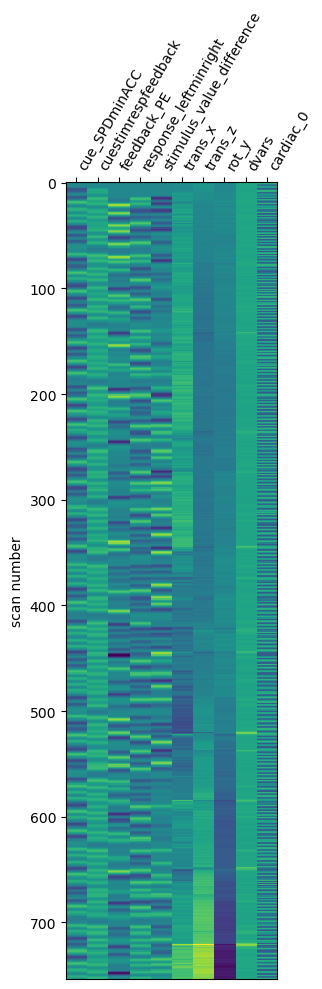

In [104]:
from nilearn import plotting
plotting.plot_design_matrix(flm.design_matrices_[0].iloc[:,:20:2])

<AxesSubplot:>

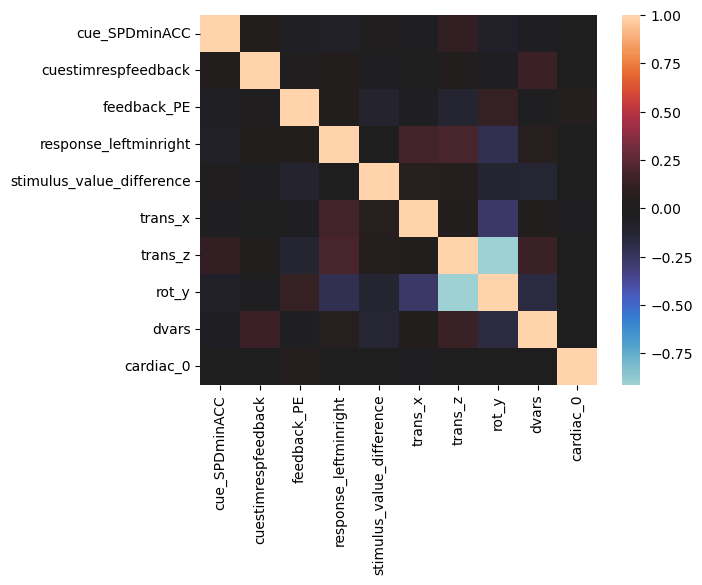

In [105]:
sns.heatmap(flm.design_matrices_[0].iloc[:,:20:2].corr(), center=0)

## Compute & warp contrasts

In [106]:
def compute_contrasts(comb, contrast_mapping, model_n, smoothing_fwhm, space='T1w', overwrite=False, save_dir_name='../derivatives/glm_nilearn/subject_level_model'):
    sub,ses,task = comb
    # check for existing model
    smoothing_fwhm_str = str(smoothing_fwhm).replace('.', 'p')
    flm_fn = make_first_level_model_fn(sub, ses, task, smoothing_fwhm, model_n, space, save_dir_name=save_dir_name)
    if not os.path.exists(flm_fn):
        raise(IOError(f"Model doesn''t exist! expected to find it at {flm_fn}"))

    # check for existing output fns
    stat_map_name = 'z_score'
    to_compute = {} #copy.copy(contrast_mapping)
    for contrast_name, contrast in contrast_mapping.items():
        save_fn = flm_fn.replace('desc-first-level-model.pkl', f'desc-contrast-{contrast_name}_{stat_map_name}.nii.gz')
        if (not os.path.exists(save_fn)) or overwrite:
            # skip this one
            to_compute[contrast_name] = contrast
    
    if len(to_compute) == 0:
        print('All contrasts already computed')
        return 0
        
    # load first level models & make contrast maps
    first_level_model = load_first_level_model(flm_fn)

    for contrast_name, contrast in to_compute.items():
        
        # save all stat maps
        stat_maps = first_level_model.compute_contrast(contrast, output_type='all')
        for stat_map_name, stat_map in stat_maps.items():
            if not stat_map_name in ['z_score', 'effect_size', 'effect_variance']:
                continue  # drop p-value and 'stat'
            save_fn = flm_fn.replace('desc-first-level-model.pkl', f'desc-contrast-{contrast_name}_{stat_map_name}.nii.gz')
            stat_map.to_filename(save_fn)
            
            # warp
            stat_map_warped = apply_warp(save_fn, sub)
            # move
            os.rename(stat_map_warped, save_fn.replace('space-T1w', 'space-MNI152NLin2009cAsym'))
    
    return 0


save_dir_name = '../derivatives/glm_nilearn/subject_level_model'
space = 'T1w'

## weirdly this doesn't work with joblib, so move to multiprocess
for model_n in ['1-z']: #', '0b-dm', '0a', '0V', '0V-dm', '0PE', '0PE-dm']: #,2]:
    if model_n == '1-z':
        contrast_mapping = {'leftminright': 'response_leftminright',
                            'spdminacc': 'cue_SPDminACC',
                            'cuestimrespfeedback': 'cuestimrespfeedback',
                            'stimulus_value_diff' : 'stimulus_value_difference',
                            'RPE': 'feedback_PE'}

    for smoothing_fwhm in [1.5]:
        joblib.Parallel(n_jobs=12, verbose=True)(joblib.delayed(compute_contrasts)( (sub,ses,task), contrast_mapping=contrast_mapping, 
                                                                                   model_n=model_n, smoothing_fwhm=smoothing_fwhm, overwrite=False) for sub,ses,task,_ in to_fit)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is exp

## Group level model

In [109]:
## find RL-ARD parameters
parameters = pd.read_csv('../derivatives/behavior/task-rlsat_model-RLARD-v0B_group_parameters.tsv', sep='\t')
for colname in ['v0_cues-a', 'B_cues-a']:
    parameters[colname+'_z'] = (parameters[colname]-parameters[colname].mean())/parameters[colname].std()

parameters['subject_label'] = parameters['subjects'].apply(lambda x: str(x).zfill(3))
parameters

subjects        v0  v0_cues-a         B  B_cues-a        t0        wd  \
1           2  2.910290  -1.025682  2.025338 -1.285449 -2.081995  0.482456   
9           3  5.001773  -0.676252  2.914672 -0.720127 -2.015544  0.617985   
17          4  2.066921   0.002230  1.810308 -0.239417 -2.688561  0.439883   
25          5  3.109358   0.425137  1.414521 -0.234553 -1.341479  0.793488   
33          6  2.724463   0.225878  1.782015 -0.501218 -1.346338  1.022151   
41          7  2.465166   0.776851  1.477023 -0.570150 -1.582741  0.697244   
49          8  3.059988   0.943215  2.060362 -0.372719 -1.829220  0.959709   
57          9  1.925734  -0.715873  2.038763 -0.800146 -2.659855  0.312221   
65         10  5.349030   0.179183  2.751800 -0.367664 -1.587286  1.276061   
73         11  1.392654  -0.889986  1.207700 -1.297593 -2.013090  0.358587   
81         12  2.377211   0.223554  1.406038 -0.406419 -1.434488  0.697037   
89         13  3.067689  -0.204051  2.267703 -0.435720 -2.482974  0.518980   
97         14  2.301932  -0.019596  1.729650 -0.531530 -1.948286  0.823669   
105        15  3.505234  -0.399357  2.240240 -0.698170 -2.632993  0.323505   
113        16  2.416611   0.053450  1.829410 -0.503905 -1.885722  0.952057   
121        17  3.450697  -0.391306  2.083485 -0.519192 -2.307799  0.591644   
129        18  1.672132  -0.320093  1.452521 -0.637512 -2.470639  0.254159   
137        19  2.950180   0.520995  1.685127 -0.521726 -1.763405  0.982301   
145        20  2.810588   0.621114  1.612971 -0.493808 -1.305971  0.319912   
153        23  2.842503   0.290832  1.378497 -0.673986 -2.172391  0.526118   
161        24  2.479413   0.451472  1.627425 -0.341923 -1.387711  0.986454   
169        26  2.677254   0.547841  1.772615 -0.694317 -1.539822  0.914923   
177        29  2.841622   0.444503  2.015574 -0.076573 -1.561195  0.964931   
185        30  1.939534  -0.068025  1.820751 -0.457237 -2.628330  0.419888   
193        31  3.492826  -0.289639  2.245816 -0.393338 -1.863893  0.592273   
201        32  2.871120   0.358952  1.617247 -0.537926 -1.936745  0.819250   
209        33  3.126784   0.086385  2.029879 -0.515228 -2.033580  1.060510   
217        34  2.563433   0.135652  2.069329 -0.748747 -2.097669  0.556827   
225        35  2.759036   0.859075  1.746180 -0.569470 -1.512652  1.155651   
233        36  2.623295  -0.354199  2.182308 -0.667733 -2.559693  0.620646   
241        37  2.520945  -0.159382  1.605963 -0.409275 -2.608862  0.386426   
249        38  3.186467  -0.471345  2.663184 -0.814205 -2.262604  0.879616   
257        39  2.412431  -0.156798  1.534999 -0.306438 -2.117646  0.670241   
265        41  2.863761  -0.212467  1.877203 -0.535749 -1.788821  0.856066   
273        42  2.814815   0.208848  1.795676 -0.573350 -1.844200  0.832971   
281        43  2.190365  -0.034459  1.693181 -0.269844 -2.601612  0.439011   
289        44  3.672790  -0.176288  2.282236 -0.325096 -2.051888  0.894142   

           ws     alpha  v0_cues-a_z  B_cues-a_z subject_label  
1   -3.102424 -0.876571    -2.220119   -3.012546           002  
9   -2.908631 -0.531840    -1.479199   -0.722339           003  
17   0.833676 -2.092316    -0.040566    1.225095           004  
25  -1.935182 -1.212809     0.856154    1.244799           005  
33  -1.461934 -1.173075     0.433652    0.164499           006  
41  -1.294479 -1.367649     1.601918   -0.114757           007  
49   0.184991 -1.562185     1.954671    0.685069           008  
57  -2.455011 -1.077413    -1.563211   -1.046506           009  
65  -0.683083 -1.090450     0.334641    0.705544           010  
73  -2.128562 -1.421924    -1.932394   -3.061745           011  
81  -1.919341 -0.935069     0.428724    0.548542           012  
89  -1.037174 -1.578101    -0.477958    0.429838           013  
97  -1.028959 -1.756620    -0.086845    0.041701           014  
105  0.211514 -1.737492    -0.892079   -0.633386           015  
113 -2.417605 -1.016027     0.068041    0.153613           016  


In [110]:
fwhm = 1.5
fwhm_str = str(fwhm).replace('.', 'p')
model_n = '1-z'

contrast_name = 'SPD-ACC'
imgs = sorted(glob.glob(f'../derivatives/glm_nilearn/subject_level_model/sub-*/ses-rlsat/func/fwhm-*/model-*/*MNI*desc-contrast-*_effect_size*'))
regex = re.compile('.*/sub-(?P<sub>\d+)/.*/fwhm-(?P<fwhm>\S+)/model-(?P<model_n>\S+)/sub-.*_desc-contrast-(?P<contrast_name>\S+)_effect_size.nii.gz')

df = pd.DataFrame({'effects_map_path':imgs})
df['subject_label'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['sub'])
df['fwhm'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['fwhm'])
df['model_n'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['model_n'])
df['map_name'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['contrast_name'])
df.head()

effects_map_path subject_label fwhm  \
0  ../derivatives/glm_nilearn/subject_level_model...           002  1p5   
1  ../derivatives/glm_nilearn/subject_level_model...           002  1p5   
2  ../derivatives/glm_nilearn/subject_level_model...           002  1p5   
3  ../derivatives/glm_nilearn/subject_level_model...           002  1p5   
4  ../derivatives/glm_nilearn/subject_level_model...           002  1p5   

  model_n             map_name  
0   0a-dm                  RPE  
1   0a-dm  cuestimrespfeedback  
2   0a-dm         leftminright  
3   0a-dm            spdminacc  
4   0a-dm  stimulus_value_diff

In [111]:
def save_second_level_spm(spm, first_level_contrast_name, second_level_contrast_name, fwhm, model_n, save_dir_name='../derivatives/glm_nilearn/group_level_model/ses-rlsat'):
    fwhm = str(fwhm).replace('.', 'p')
    save_fn = os.path.join(save_dir_name, f'fwhm-{fwhm}/model-{model_n}/firstlevelcontrast-{first_level_contrast_name}_secondlevelcontrast-{second_level_contrast_name}.nii.gz')
    
    if not os.path.exists(os.path.dirname(save_fn)):
        os.makedirs(os.path.dirname(save_fn))
    
    spm.to_filename(save_fn)
    nilearn.image.math_img('-nii', nii=spm).to_filename(save_fn.replace('.nii.gz', '-neg.nii.gz'))

In [112]:
def fit_second_level_models(first_level_contrast, second_level_contrast, fwhm, model_n, df, parameters):
    print(f'{fwhm} {model_n} {first_level_contrast}')
    df_in = df.loc[(df.map_name==first_level_contrast) & (df.fwhm==str(fwhm).replace('.', 'p')) & (df.model_n==str(model_n))]
    dm = pd.merge(df_in, parameters[['subject_label', 'B_cues-a_z', 'v0_cues-a_z']]) #, 'V0.SPD-ACC_z']])
    dm['intercept'] = 1

    if first_level_contrast == 'spdminacc':
        dm_in = dm[['intercept', 'B_cues-a_z', 'v0_cues-a_z']] #, 'V0.SPD-ACC_z']]
    else:
        dm_in = dm[['intercept']]
    
    slm = SecondLevelModel()
    slm_fitted = slm.fit(second_level_input=df_in.effects_map_path.values.tolist(), design_matrix=dm_in)

    # Intercept, threshold covariance, urgency covariance
    cmap = slm_fitted.compute_contrast('intercept', output_type='z_score')
    save_second_level_spm(cmap, first_level_contrast_name=first_level_contrast, second_level_contrast_name=second_level_contrast, fwhm=fwhm, model_n=model_n)

    if first_level_contrast == 'spdminacc':
        cmap = slm_fitted.compute_contrast('B_cues-a_z', output_type='z_score')
        save_second_level_spm(cmap, first_level_contrast_name=first_level_contrast, second_level_contrast_name='threshold_z', fwhm=fwhm, model_n=model_n)
        
        cmap = slm_fitted.compute_contrast('v0_cues-a_z', output_type='z_score')
        save_second_level_spm(cmap, first_level_contrast_name=first_level_contrast, second_level_contrast_name='urgency_z', fwhm=fwhm, model_n=model_n)

In [113]:
# import itertools
model_ns = ['1-z']
for model_n in model_ns:
    all_combs = list(itertools.product(df.loc[df.model_n.isin([model_n]), 'map_name'].unique().tolist(), ['intercept'], [1.5], [model_n]))

    _ = joblib.Parallel(n_jobs=10, verbose=1)(joblib.delayed(fit_second_level_models)(first_level_contrast, second_level_contrast, fwhm, model_n, 
                                                                                      df=df, parameters=parameters) for first_level_contrast,second_level_contrast,fwhm,model_n in all_combs)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is exp

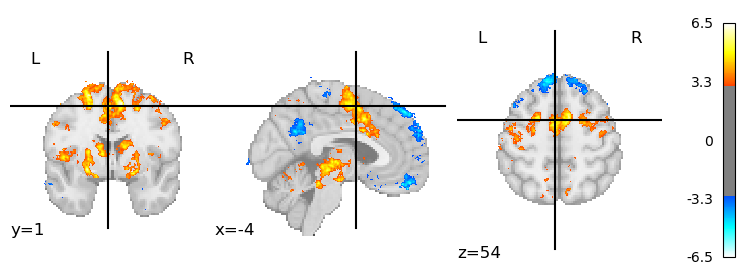

In [114]:
sat_intercept = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-z/firstlevelcontrast-spdminacc_secondlevelcontrast-intercept.nii.gz')
sat_intercept_thresh, sat_thresh = nilearn.glm.threshold_stats_img(stat_img=sat_intercept, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(sat_intercept, threshold=sat_thresh)

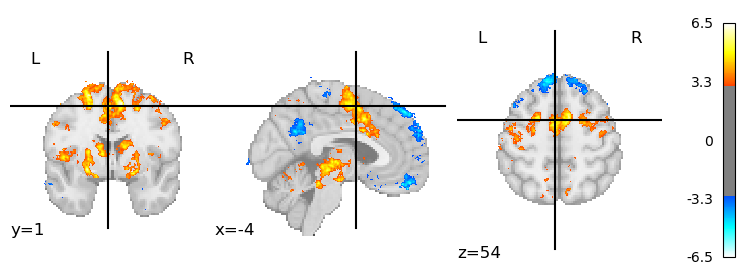

In [115]:
sat_intercept = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-z/firstlevelcontrast-spdminacc_secondlevelcontrast-intercept.nii.gz')
sat_intercept_thresh, sat_thresh = nilearn.glm.threshold_stats_img(stat_img=sat_intercept, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(sat_intercept, threshold=sat_thresh)

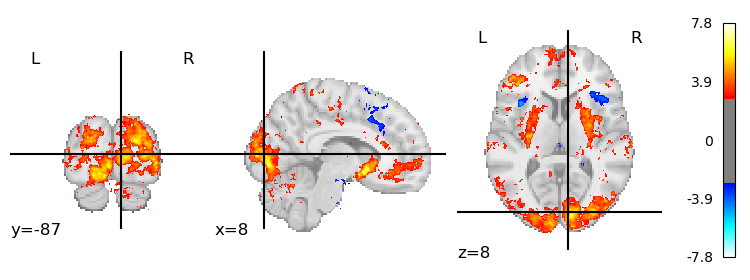

In [116]:
rpe_intercept = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-z/firstlevelcontrast-RPE_secondlevelcontrast-intercept.nii.gz')
rpe_intercept_thresh, rpe_thresh = nilearn.glm.threshold_stats_img(stat_img=rpe_intercept, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(rpe_intercept, threshold=rpe_thresh)

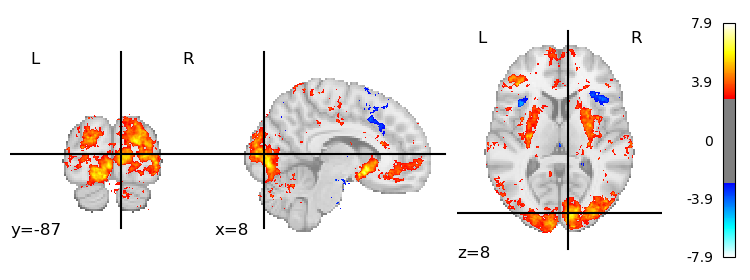

In [37]:
rpe_intercept = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-dm/firstlevelcontrast-RPE_secondlevelcontrast-intercept.nii.gz')
rpe_intercept_thresh, rpe_thresh = nilearn.glm.threshold_stats_img(stat_img=rpe_intercept, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(rpe_intercept, threshold=rpe_thresh)

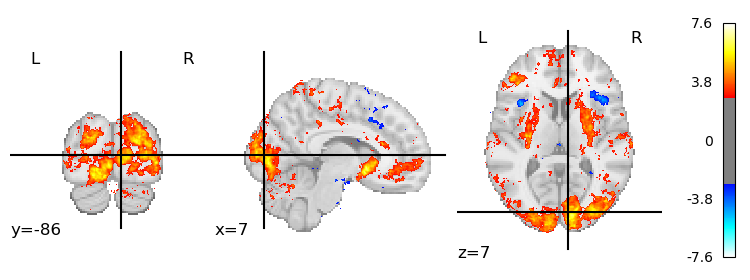

In [39]:
rpe_intercept = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-0a-dm/firstlevelcontrast-RPE_secondlevelcontrast-intercept.nii.gz')
rpe_intercept_thresh, rpe_thresh = nilearn.glm.threshold_stats_img(stat_img=rpe_intercept, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(rpe_intercept, threshold=rpe_thresh)

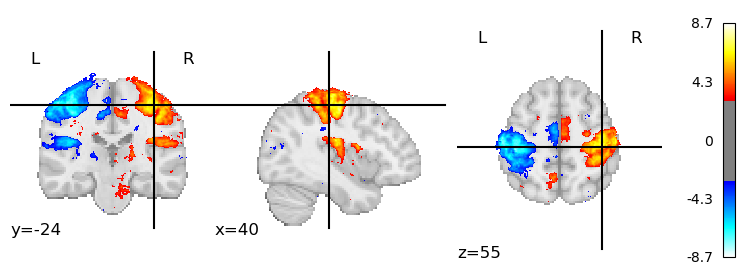

In [117]:
motor_intercept = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-z/firstlevelcontrast-leftminright_secondlevelcontrast-intercept.nii.gz')
motor_intercept_thresh, motor_thresh = nilearn.glm.threshold_stats_img(stat_img=motor_intercept, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(motor_intercept, threshold=motor_thresh)

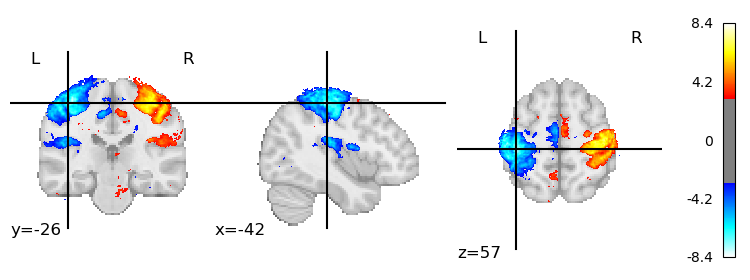

In [41]:
motor_intercept = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-0a-dm/firstlevelcontrast-leftminright_secondlevelcontrast-intercept.nii.gz')
motor_intercept_thresh, motor_thresh = nilearn.glm.threshold_stats_img(stat_img=motor_intercept, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(motor_intercept, threshold=motor_thresh)

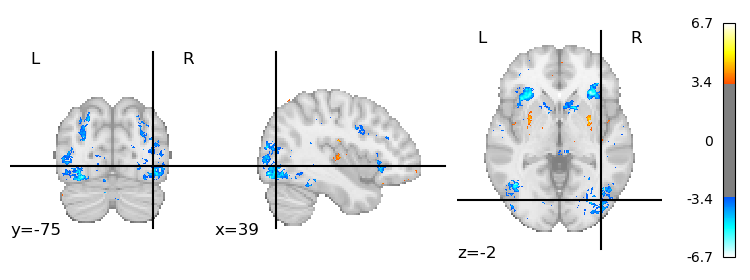

1.5 1-z RPE
1.5 1-z cuestimrespfeedback
1.5 1-z leftminright
1.5 1-z stimulus_value_diff
1.5 1-z spdminacc


In [119]:
value_intercept = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-dm/firstlevelcontrast-stimulus_value_diff_secondlevelcontrast-intercept.nii.gz')
value_intercept_thresh, value_thresh = nilearn.glm.threshold_stats_img(stat_img=value_intercept, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(value_intercept, threshold=value_thresh)

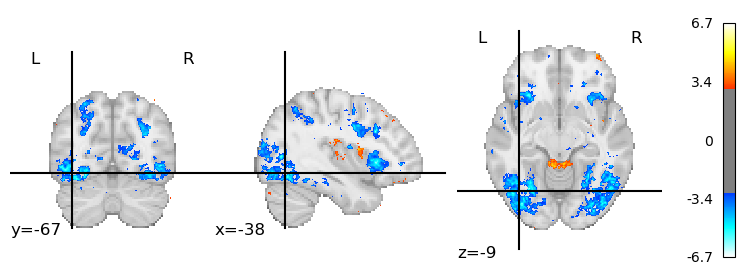

In [118]:
value_intercept = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-z/firstlevelcontrast-stimulus_value_diff_secondlevelcontrast-intercept.nii.gz')
value_intercept_thresh, value_thresh = nilearn.glm.threshold_stats_img(stat_img=value_intercept, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(value_intercept, threshold=value_thresh)

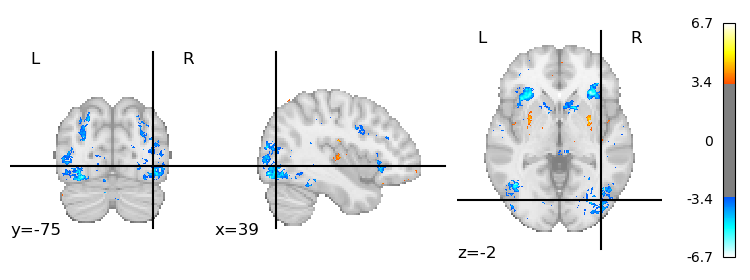

In [39]:
value_intercept = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-dm/firstlevelcontrast-stimulus_value_diff_secondlevelcontrast-intercept.nii.gz')
value_intercept_thresh, value_thresh = nilearn.glm.threshold_stats_img(stat_img=value_intercept, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(value_intercept, threshold=value_thresh)

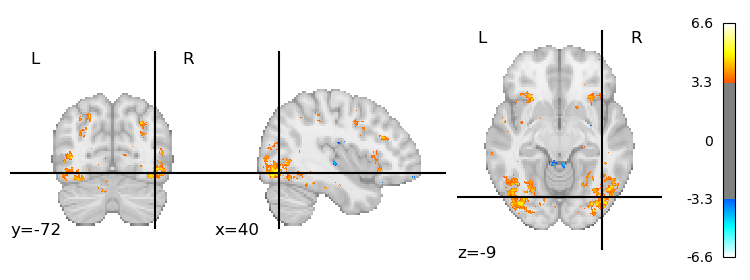

In [42]:
value_intercept = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-0a-dm/firstlevelcontrast-stimulus_value_diff_secondlevelcontrast-intercept.nii.gz')
value_intercept_thresh, value_thresh = nilearn.glm.threshold_stats_img(stat_img=value_intercept, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(value_intercept, threshold=value_thresh)

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.7677823582253565. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/plotting/find_cuts.py:69: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


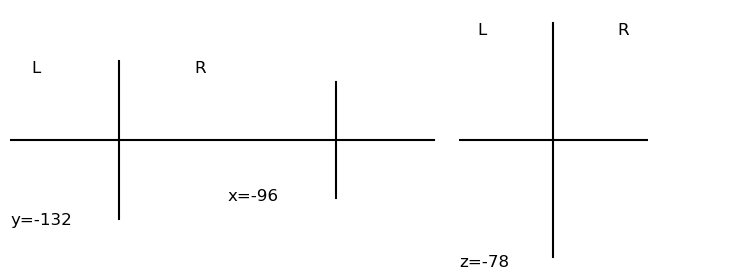

In [40]:
#
sat_B = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-dm/firstlevelcontrast-spdminacc_secondlevelcontrast-threshold_z.nii.gz')
sat_B_thresh, sat_b_threshold_value = nilearn.glm.threshold_stats_img(stat_img=sat_B, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(sat_B_thresh, threshold=2.3)

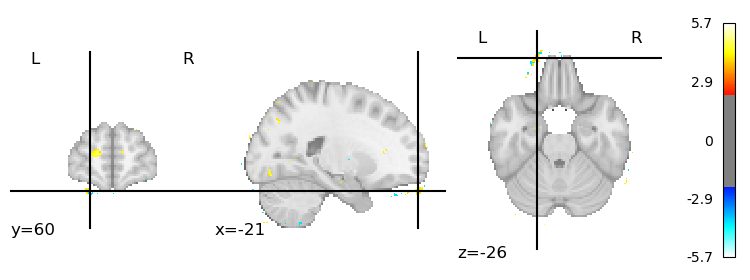

In [46]:
#
sat_B = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-0a-dm/firstlevelcontrast-spdminacc_secondlevelcontrast-threshold_z.nii.gz')
sat_B_thresh, sat_b_threshold_value = nilearn.glm.threshold_stats_img(stat_img=sat_B, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(sat_B_thresh, threshold=2.3)

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.82278787035976. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "


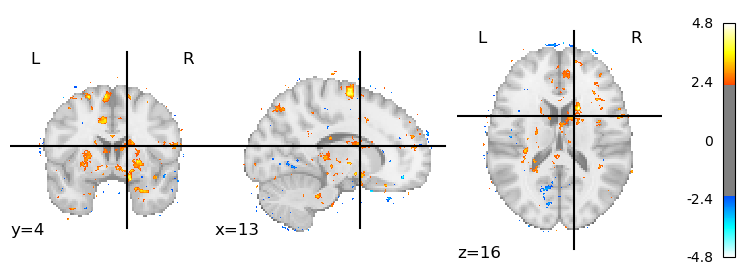

In [41]:
#
sat_u = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-dm/firstlevelcontrast-spdminacc_secondlevelcontrast-urgency_z.nii.gz')
sat_u_thresh, sat_u_threshold_value = nilearn.glm.threshold_stats_img(stat_img=sat_u, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(sat_u, threshold=2.3)

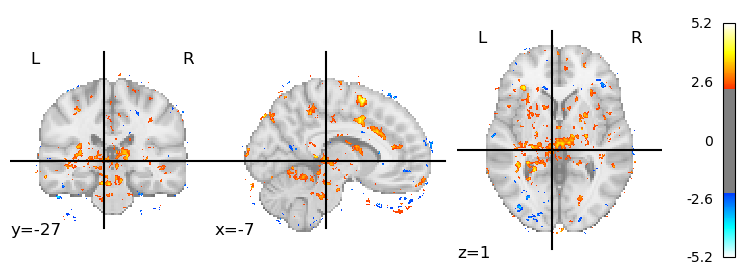

In [48]:
#
sat_u = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-0a-dm/firstlevelcontrast-spdminacc_secondlevelcontrast-urgency_z.nii.gz')
sat_u_thresh, sat_u_threshold_value = nilearn.glm.threshold_stats_img(stat_img=sat_u, height_control='fdr', alpha=0.05)
plotting.plot_stat_map(sat_u, threshold=2.3)

## Extract subject-level betas along striatal axes

In [64]:
import nilearn
from nilearn import image

In [117]:
all_fns = sorted(glob.glob('../derivatives/glm_nilearn/subject_level_model/sub-0*/ses-rlsat/'))
regex = re.compile('.*/sub-(?P<sub>\d+).*')
all_subs = [regex.match(x)['sub'] for x in all_fns]
# all_subs

In [ ]:
dfs = []
for gradient_n in [0,1,2,3,4,5,6,7,8,9]:
    print(gradient_n)
    #gradient_n = 0
    gradient_l_mni = f'../derivatives/masks_spectral_embeddings/mni09b/massp2021-subcortex_avg-str_hem-l_decade-18to40_n54_sme_dimension-{gradient_n}.nii.gz'
    gradient_min = nib.load(gradient_l_mni).get_fdata().min()
    gradient_max = nib.load(gradient_l_mni).get_fdata().max()
    cuts = np.linspace(gradient_min, gradient_max, num=50)

    for sub in all_subs[:-1]:
        for contrast in ['leftminright', 'spdminacc', 'RPE', 'stimulus_value_diff']:
            betamap_epispace = f'../derivatives/glm_nilearn/subject_level_model/sub-{sub}/ses-rlsat/func/fwhm-1p5/model-1-dm/sub-{sub}_ses-rlsat_task-rlsat_space-T1w_desc-contrast-{contrast}_effect_size.nii.gz'
            gradient_l_epispace = f'../derivatives/masks_spectral_embeddings/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-str-l_dim-{gradient_n}.nii.gz'
            gradient_r_epispace = f'../derivatives/masks_spectral_embeddings/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-str-r_dim-{gradient_n}.nii.gz'
            subj_str_l_mask = f'../derivatives/masks_massp_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-Str-l.nii.gz'
            subj_str_r_mask = f'../derivatives/masks_massp_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-Str-r.nii.gz'
            # gradient_r_epispace = f'../derivatives/masks_spectral_embeddings/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-str-r_dim-{gradient_n}.nii.gz'

            betas = nib.load(betamap_epispace).get_fdata()
            str_l = nib.load(subj_str_l_mask).get_fdata()
            str_r = nib.load(subj_str_r_mask).get_fdata()
            

            idx_l = np.digitize(nib.load(gradient_l_epispace).get_fdata(), bins=cuts)
            idx_r = np.digitize(nib.load(gradient_r_epispace).get_fdata(), bins=cuts)
            for cut_n, gradient_val in enumerate(cuts):
                voxels_r = betas[(idx_r==cut_n) & (str_r>0.01)]
                voxels_l = betas[(idx_l==cut_n) & (str_l>0.01)]
                dfs.append(pd.DataFrame({'subjects':sub, 
                                         'gradient_n': gradient_n, 
                                         'contrast': contrast, 
                                         'gradient_value': gradient_val, 
                                         'Str_l': np.mean(voxels_l), 
                                         'Str_r': np.mean(voxels_r),
                                         'cut_n': cut_n}, index=[0]))

df = pd.concat(dfs)

0


/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in s

1


/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in s

2


/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in s

3


/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in s

4


/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in s

5


/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in s

6


/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in s

7


/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stevenm/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in s

In [230]:
#df = pd.concat(dfs)
df
aggregated = df.groupby(['gradient_n', 'gradient_value', 'contrast']).mean().reset_index()
aggregated

/tmp/ipykernel_904764/441214132.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated = df.groupby(['gradient_n', 'gradient_value', 'contrast']).mean().reset_index()


gradient_n  gradient_value             contrast      Str_l      Str_r
0              0       -0.004491                  RPE        NaN        NaN
1              0       -0.004491         leftminright        NaN        NaN
2              0       -0.004491            spdminacc        NaN        NaN
3              0       -0.004491  stimulus_value_diff        NaN        NaN
4              0       -0.004302                  RPE   4.456457   3.599767
...          ...             ...                  ...        ...        ...
1595           7        0.006721  stimulus_value_diff  18.464690  18.158287
1596           7        0.006994                  RPE   8.899458   7.856338
1597           7        0.006994         leftminright  -5.154918   3.443136
1598           7        0.006994            spdminacc   1.096307   1.956629
1599           7        0.006994  stimulus_value_diff   3.995880   4.416238

[1600 rows x 5 columns]

0
1
2
3


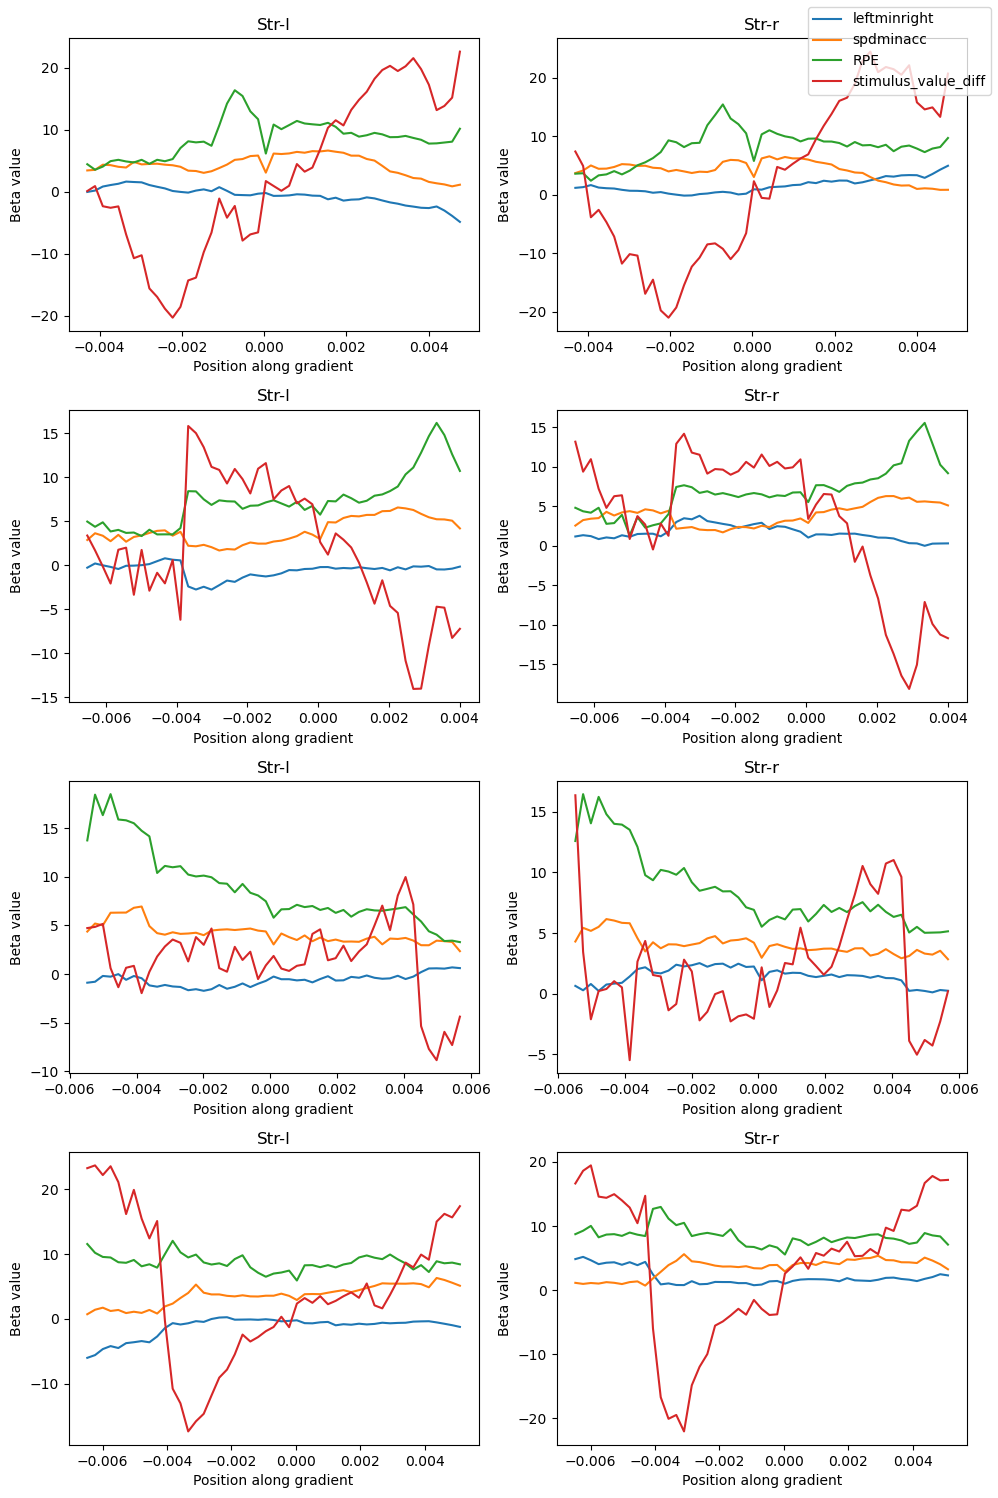

In [185]:
# df = pd.concat(dfs)
# aggregated = df.groupby('gradient_value').mean().reset_index()
f, ax = plt.subplots(4,2, figsize=(10,15))
# ax[0].set_xlabel('Position along gradient')
# ax[0].set_ylabel('Beta value')
# ax[0].set_title('Str-l')
# ax[1].set_xlabel('Position along gradient')
# ax[1].set_ylabel('Beta value')
# ax[1].set_title('Str-r')

for gradient in range(4):
    print(gradient)
    ax[gradient,0].set_xlabel('Position along gradient')
    ax[gradient,0].set_ylabel('Beta value')
    ax[gradient,0].set_title('Str-l')
    ax[gradient,1].set_xlabel('Position along gradient')
    ax[gradient,1].set_ylabel('Beta value')
    ax[gradient,1].set_title('Str-r')
    
    for contrast in ['leftminright', 'spdminacc', 'RPE', 'stimulus_value_diff']:
        tmp = aggregated[(aggregated.contrast==contrast)&(aggregated.gradient_n==gradient)]
        ax[gradient,0].plot(tmp['gradient_value'], tmp['Str_l'], '-')
        ax[gradient,1].plot(tmp['gradient_value'], tmp['Str_r'], '-', label=contrast if gradient==0 else None)
    # break
f.legend()
f.tight_layout()

In [231]:
df_long = df.melt(id_vars=['subjects', 'gradient_n', 'contrast', 'gradient_value'], var_name='ROI', value_name='beta')
df_long.head()

subjects  gradient_n      contrast  gradient_value    ROI      beta
0      002           0  leftminright       -0.004491  Str_l       NaN
1      002           0  leftminright       -0.004302  Str_l  3.057594
2      002           0  leftminright       -0.004113  Str_l  4.763539
3      002           0  leftminright       -0.003924  Str_l  5.524192
4      002           0  leftminright       -0.003736  Str_l  4.452764

In [232]:
df_long.contrast.unique()

array(['leftminright', 'spdminacc', 'RPE', 'stimulus_value_diff'],
      dtype=object)

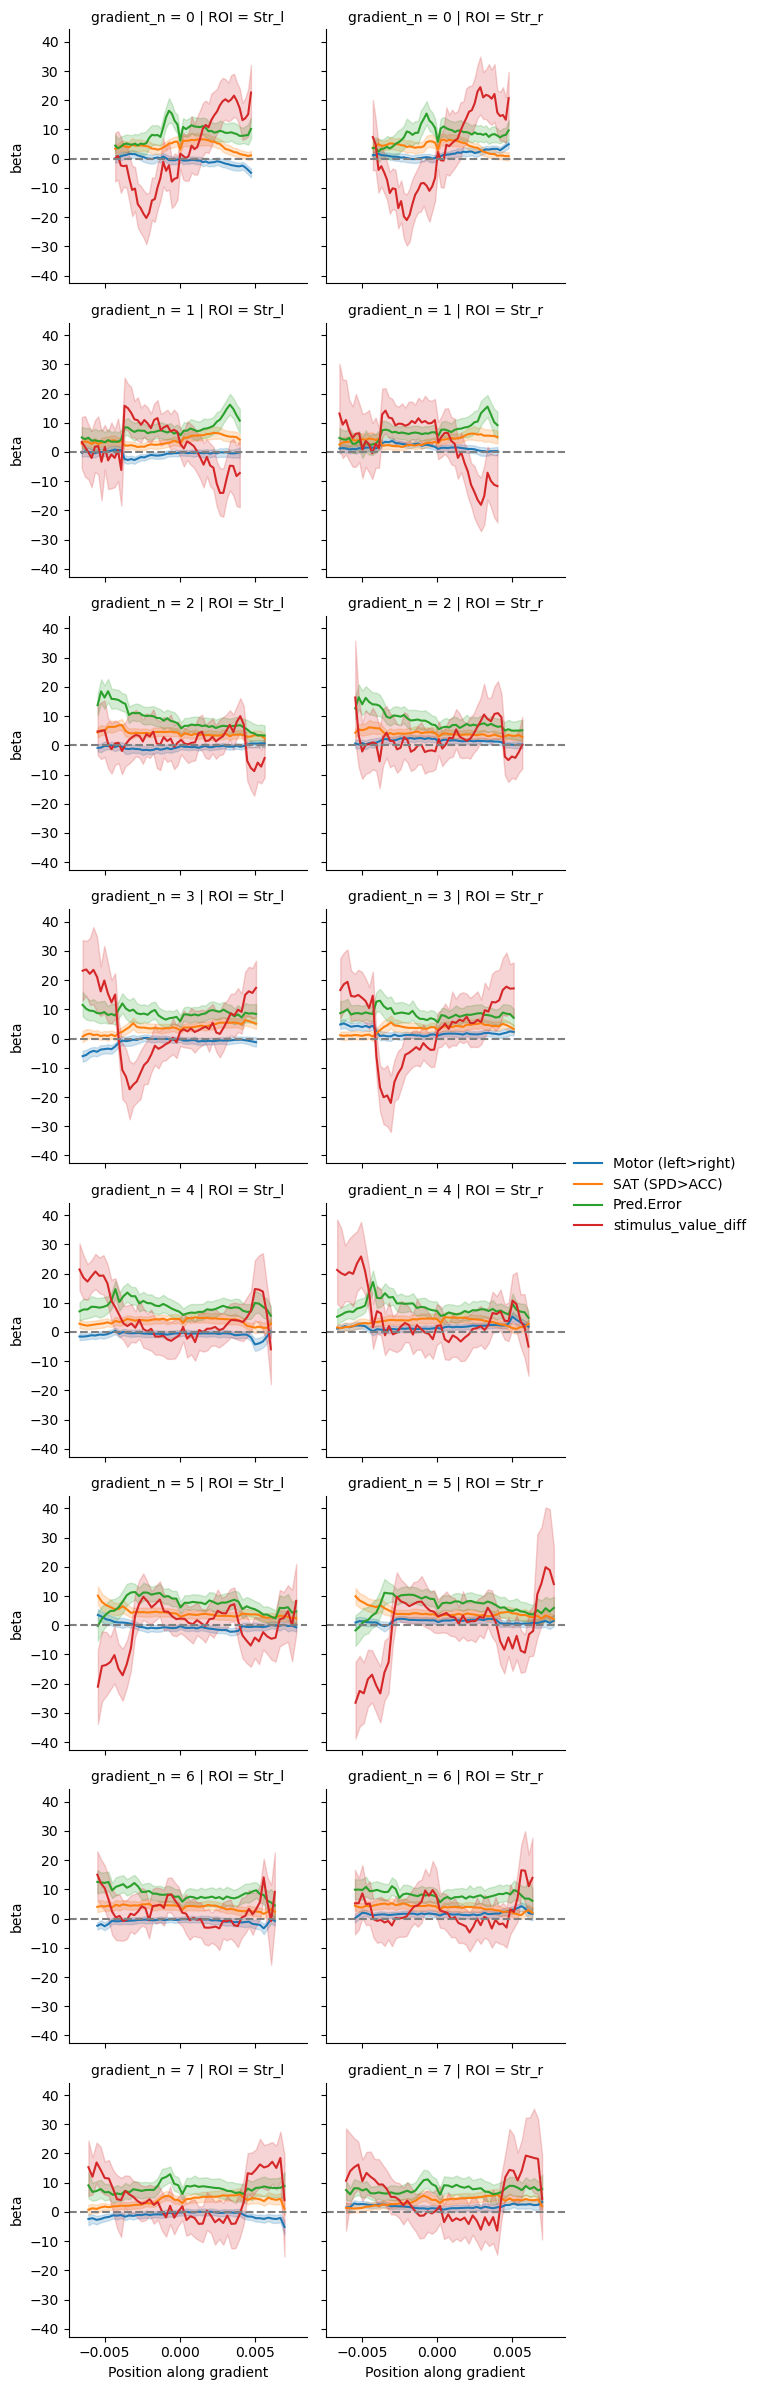

In [233]:
tmp = df_long.copy()
tmp.loc[tmp.contrast=='leftminright', 'contrast'] = 'Motor (left>right)'
tmp.loc[tmp.contrast=='spdminacc', 'contrast'] = 'SAT (SPD>ACC)'
tmp.loc[tmp.contrast=='RPE', 'contrast'] = 'Pred.Error'
tmp.loc[tmp.contrast=='stimulus_value_difference', 'contrast'] = 'Difficulty/Value'
tmp = tmp.rename(columns={'gradient_value': 'Position along gradient'})

g = sns.FacetGrid(tmp, col="ROI",  row="gradient_n")
g.map_dataframe(sns.lineplot, x="Position along gradient", y="beta", hue='contrast')
axes = g.axes.flatten()

# iterate through the axes
for i, ax in enumerate(axes):
    ax.axhline(0, ls='--', c='grey')
    
g.add_legend()

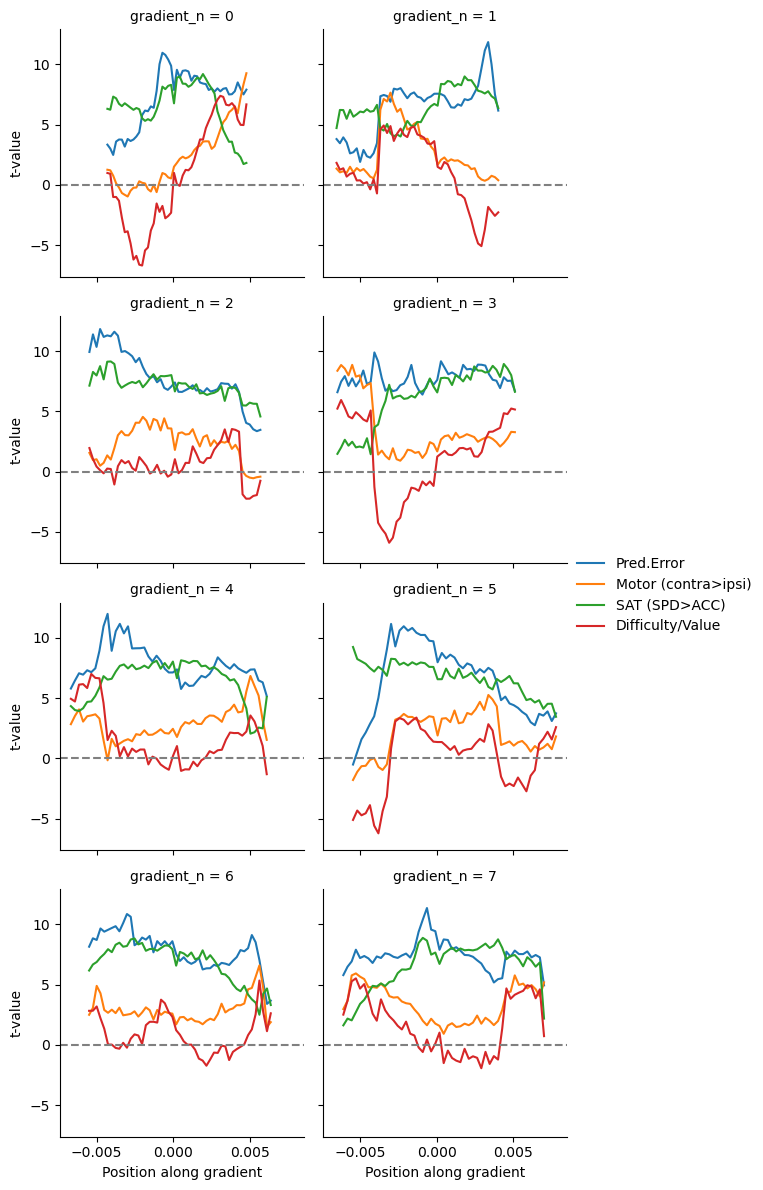

In [234]:
tmp = df_long.copy()
tmp.loc[(tmp.contrast=='leftminright') & (tmp.ROI=='Str_l'), 'beta'] *= -1
tmp.loc[(tmp.contrast=='leftminright'), 'contrast'] = 'contraminusipsi'
tvals_long = tmp.groupby(['gradient_n', 'contrast', 'gradient_value'])['beta'].apply(lambda x: x.mean()/((x.std()/np.sqrt(x.shape[0])))).reset_index()
tvals_long['t-value'] = tvals_long['beta']
tvals_long

tmp = tvals_long.copy()
tmp.loc[tmp.contrast=='contraminusipsi', 'contrast'] = 'Motor (contra>ipsi)'
tmp.loc[tmp.contrast=='spdminacc', 'contrast'] = 'SAT (SPD>ACC)'
tmp.loc[tmp.contrast=='RPE', 'contrast'] = 'Pred.Error'
tmp.loc[tmp.contrast=='stimulus_value_diff', 'contrast'] = 'Difficulty/Value'
tmp = tmp.rename(columns={'gradient_value': 'Position along gradient'})

g = sns.FacetGrid(tmp, col="gradient_n", col_wrap=2)
g.map_dataframe(sns.lineplot, x="Position along gradient", y="t-value", hue='contrast')
axes = g.axes.flatten()

# iterate through the axes
for i, ax in enumerate(axes):
    ax.axhline(0, ls='--', c='grey')
    
g.add_legend()

## How many gradients do we need to predict each voxel's response?

In [236]:
import statsmodels
import statsmodels.api as sm

In [237]:
df_long

subjects  gradient_n             contrast  gradient_value    ROI  \
0           002           0         leftminright       -0.004491  Str_l   
1           002           0         leftminright       -0.004302  Str_l   
2           002           0         leftminright       -0.004113  Str_l   
3           002           0         leftminright       -0.003924  Str_l   
4           002           0         leftminright       -0.003736  Str_l   
...         ...         ...                  ...             ...    ...   
115195      043           7  stimulus_value_diff        0.005904  Str_r   
115196      043           7  stimulus_value_diff        0.006176  Str_r   
115197      043           7  stimulus_value_diff        0.006449  Str_r   
115198      043           7  stimulus_value_diff        0.006721  Str_r   
115199      043           7  stimulus_value_diff        0.006994  Str_r   

             beta  
0             NaN  
1        3.057594  
2        4.763539  
3        5.524192  
4        4.452764  
...           ...  
115195   4.745848  
115196  -2.053793  
115197 -10.514179  
115198 -24.834993  
115199 -39.123714  

[115200 rows x 6 columns]

In [240]:
beta_per_ROI = df_long.groupby(['contrast', 'gradient_n', 'gradient_value', 'ROI']).mean().reset_index()

/tmp/ipykernel_904764/1370001325.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  beta_per_ROI = df_long.groupby(['contrast', 'gradient_n', 'gradient_value', 'ROI']).mean().reset_index()


In [ ]:
pd.pivot_table(

In [249]:
tmp

subjects  gradient_n             contrast  gradient_value    ROI  \
0           002           0         leftminright       -0.004491  Str_l   
1           002           0         leftminright       -0.004302  Str_l   
2           002           0         leftminright       -0.004113  Str_l   
3           002           0         leftminright       -0.003924  Str_l   
4           002           0         leftminright       -0.003736  Str_l   
...         ...         ...                  ...             ...    ...   
108195      002           7  stimulus_value_diff        0.005904  Str_r   
108196      002           7  stimulus_value_diff        0.006176  Str_r   
108197      002           7  stimulus_value_diff        0.006449  Str_r   
108198      002           7  stimulus_value_diff        0.006721  Str_r   
108199      002           7  stimulus_value_diff        0.006994  Str_r   

            beta  
0            NaN  
1       3.057594  
2       4.763539  
3       5.524192  
4       4.452764  
...          ...  
108195  6.301924  
108196  4.595087  
108197  3.237592  
108198  3.057287  
108199  5.319718  

[3200 rows x 6 columns]

In [248]:
tmp.pivot_table(values='beta', index=['ROI'], columns='contrast')

contrast       RPE  leftminright  spdminacc  stimulus_value_diff
ROI                                                             
Str_l     4.877168      2.492191  -1.081438             4.587290
Str_r     2.574112      3.851093  -0.634608             3.398106

In [ ]:
betas = gamma*locations
betas = matrix of [n_voxels x n_contrasts]
locations = matrix of [n_voxels x n_gradients

# GLM with gradients as regressors

In [32]:
import numpy as np
import nibabel as nib
import nilearn
from nilearn import maskers, image, plotting
import glob
import os

## We need: Gradient matrix G; signal matrix y; design matrix X

In [129]:
def get_masker(mask):
    # create voxel map
    mask_data = mask.get_fdata()
    mask_data[mask_data==True] = np.arange(mask_data.sum())
    subj_mask_numbered = nib.Nifti1Image(mask_data, header=mask.header, affine=mask.affine)
    
    # extract gradients
    masker = maskers.NiftiLabelsMasker(labels_img=subj_mask_numbered)
    return masker

def get_mask(subject, roi='Str', hemisphere='r'):
    # Striatum mask in T1w space
    subj_mask = nib.load(f'../derivatives/masks_massp_func/sub-{subject}/anat/sub-{subject}_space-T1w_desc-mask-{roi}-{hemisphere}.nii.gz')
    subj_mask_bin = image.math_img('nii>.01', nii=subj_mask)
    
    return subj_mask, subj_mask_bin
    
def get_G(subject, roi='Str', hemisphere='r'):
    
    subj_mask, subj_mask_bin = get_mask(subject, roi, hemisphere)
    
    # mask out all zero voxels
    # add binary mask as intercept 'gradient'
    all_gradients = sorted(glob.glob(f'../derivatives/masks_spectral_embeddings/sub-{subject}/anat/sub-{subject}_space-T1w_desc-mask-{roi.lower()}-{hemisphere}_dim-*.nii.gz'))
    all_gradients.insert(0,subj_mask_bin)
    all_gradients = image.concat_imgs(all_gradients)
    gradients_data = all_gradients.get_fdata()
    gradients_data[subj_mask.get_fdata()<0.01] = np.nan
    all_gradients = nib.Nifti1Image(gradients_data, header=all_gradients.header, affine=all_gradients.affine)

    masker = get_masker(subj_mask_bin)
    G = masker.fit_transform(all_gradients)    
    
    return G, masker


def get_y(subject, masker):
    # find y
    ## Signal matrix y
    epi_fns = sorted(glob.glob(f'../derivatives/susan_smoothed_func/sub-{subject}/ses-rlsat/func/sub-{subject}_ses-rlsat_task-rlsat_run-*_space-T1w_desc-preproc_bold_smoothed_fwhm-1p5.nii.gz'))
    timeseries = [masker.fit_transform(x) for x in epi_fns]
    timeseries_psc = [x/x.mean(0)*100-100 for x in timeseries]
    y = np.vstack(timeseries_psc)
    return y

def get_X(subject):
    ## design matrix X. For simplicity load from nilearn GLM's object
    flm = load_first_level_model(f'../derivatives/glm_nilearn/subject_level_model/sub-{subject}/ses-rlsat/func/fwhm-1p5/model-1-dm/sub-{subject}_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl')
    X = flm.design_matrices_
    X = np.vstack(X)

    return X

def fit_gradient_GLM(subject, roi, hemisphere):
    G, masker = get_G(subject, roi, hemisphere)
    y = get_y(subject, masker)
    X = get_X(subject)
    
    ## 
    X_T = X.T
    y_T = y.T
    G_T = G.T
    
    ## Inverse of G
    G_T_inv = np.linalg.pinv(G_T)
    y_adj_T = (G_T_inv@y.T).T

    # fit OLS
    gamma, residuals, rank, s = np.linalg.lstsq(X, y_adj_T)
    
    return gamma, residuals, rank, s

In [130]:
# subject = '002'
# hemisphere = 'r'
# G, masker = get_G(subject, hemisphere)
# y = get_y(subject)
# X = get_X(subject)

# X_T = X.T
# y_T = y.T
# G_T = G.T

# G_T_inv = np.linalg.pinv(G_T)

# #G_T_inv.shape

# y_adj_T = (G_T_inv@y.T).T

# gamma, residuals, rank, s = np.linalg.lstsq(X, y_adj_T)

## Fit for all subjects

In [131]:
import glob
subject_ids = [x.split('/')[-3].split('-')[1] for x in sorted(glob.glob('../derivatives/glm_nilearn/subject_level_model/sub-*/ses-rlsat/'))]
len(subject_ids)

37

In [132]:
roi = 'Tha'
hemisphere = 'r'

for subject in subject_ids:
    fn_gamma = f'./steven_fucking_around/gradient_GLMs/sub-{subject}/sub-{subject}_task-rlsat_{roi}-{hemisphere}_gradient_GLM_gamma.npy'
    if not os.path.exists(os.path.dirname(fn_gamma)):
        os.makedirs(os.path.dirname(fn_gamma))
    
    gamma, residuals, rank, s = fit_gradient_GLM(subject, roi, hemisphere)
    with open(fn_gamma, 'wb') as f:
        np.save(f, gamma)

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/tmp/ipykernel_560744/2525161281.py:69: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  gamma, residuals, rank, s = np.linalg.lstsq(X, y_adj_T)
/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/tmp/ipykernel_560744/2525161281.py:69: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to ke

ValueError: Field of view of image #1 is different from reference FOV.
Reference affine:
array([[  1.5       ,   0.        ,   0.        , -68.52120972],
       [  0.        ,   1.5       ,   0.        , -87.5749054 ],
       [  0.        ,   0.        ,   1.5       , -59.30084991],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
Image affine:
array([[  1.5       ,   0.        ,  -0.        , -68.52120972],
       [  0.        ,   1.5       ,  -0.        , -87.5749054 ],
       [  0.        ,   0.        ,   1.5       , -60.80084991],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
Reference shape:
(93, 119, 91)
Image shape:
(93, 119, 92, 1)


In [133]:
subject

'044'

## Something is weird about subject 44

## Analyze others

In [142]:
gamma_fns = sorted(glob.glob('./steven_fucking_around/gradient_GLMs/sub-*/sub-*_task-rlsat_Tha-r_gradient_GLM_gamma.npy'))
gammas = [np.load(x) for x in gamma_fns]

In [143]:
len(gammas)

36

In [144]:
gammas[4].shape

(59, 21)

In [32]:
# get mean and SE of gammas

In [145]:
gammas_combined = np.concatenate([x[:,:,np.newaxis] for x in gammas], axis=2)

In [146]:
mean_gamma = gammas_combined.mean(axis=-1)
SE_gamma = gammas_combined.std(axis=-1)/np.sqrt(gammas_combined.shape[-1])
z_gamma = mean_gamma/SE_gamma

In [147]:
# contrasts of interest:
# 0 = SAT
# 4 = PE
# 6 = LeftRight
# 7 = Value difference

In [148]:
gradient_n = 2
contrast_n = 6
z_gamma[gradient_n,contrast_n]

-6.672533034165535

In [150]:
from scipy.stats import ttest_1samp

In [151]:
gammas_combined.shape

(59, 21, 36)

In [152]:
# Get thresholded gammas
tres, pvals = ttest_1samp(gammas_combined, popmean=0, axis=-1)
gammas_thresholded = gammas_combined.copy()
gammas_thresholded[pvals>0.05] = 0    # No MC at the moment
mean_gamma_thresholded = gammas_thresholded.mean(axis=-1)

## reconstruct mean betas across striatum with population map

In [154]:
def get_masker(mask):
    # create voxel map
    mask_data = mask.get_fdata()
    mask_data[mask_data==True] = np.arange(mask_data.sum())
    subj_mask_numbered = nib.Nifti1Image(mask_data, header=mask.header, affine=mask.affine)
    
    # extract gradients
    masker = maskers.NiftiLabelsMasker(labels_img=subj_mask_numbered)
    return masker

def get_group_mask(roi, hemisphere):
    # Striatum mask in MNI space
    subj_mask = nib.load(f'./steven_fucking_around/massp2021-subcortex_avg-{roi}_hem-{hemisphere}_decade-18to40_n54.nii.gz')
    subj_mask_bin = image.math_img('nii>.01', nii=subj_mask)
    
    return subj_mask, subj_mask_bin

def get_group_G(roi, hemisphere):
    
    subj_mask, subj_mask_bin = get_group_mask(roi, hemisphere)
    
    # mask out all zero voxels
    # add binary mask as intercept 'gradient'
    all_gradients = sorted(glob.glob(f'../derivatives/masks_spectral_embeddings/mni09b/massp2021-subcortex_avg-{roi}_hem-{hemisphere}_decade-18to40_n54_sme_dimension-*.nii.gz'))
    all_gradients.insert(0,subj_mask_bin)
    all_gradients = image.concat_imgs(all_gradients)
    gradients_data = all_gradients.get_fdata()
    gradients_data[subj_mask.get_fdata()<0.01] = np.nan
    all_gradients = nib.Nifti1Image(gradients_data, header=all_gradients.header, affine=all_gradients.affine)

    masker = get_masker(subj_mask_bin)
    G = masker.fit_transform(all_gradients)    
    
    return G, masker

G, masker = get_group_G('tha', 'r')

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


In [155]:
mean_gamma.shape
G.shape

(21, 119919)

In [156]:
mean_beta = mean_gamma@G
beta_map_mni = masker.inverse_transform(mean_beta)
beta_map_mni.shape

(394, 466, 378, 59)

In [157]:
mean_beta_thresholded = mean_gamma_thresholded@G
beta_map_mni_thresholded = masker.inverse_transform(mean_beta_thresholded)
beta_map_mni_thresholded.shape

(394, 466, 378, 59)

In [158]:
contrasts = [[0, 'SAT (SPD>ACC)', 'spdminacc', 0],
             [4, 'RPE', 'RPE', 4],
             [6, 'Motor (Left>Right)', 'leftminright', 1],
             [8, 'Value/Difficulty', 'stimulus_value_diff', 2]]

In [159]:
mean_beta_voxelwise = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-dm/firstlevelcontrast-spdminacc_secondlevelcontrast-intercept.nii.gz')
mask_mni09c = image.resample_to_img(source_img = get_group_mask('tha', 'r')[1], target_img=mean_beta_voxelwise)

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [40]:
# mean_beta_voxelwise = nib.load('../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-dm/firstlevelcontrast-spdminacc_secondlevelcontrast-intercept.nii.gz')
# mask_mni09c = image.resample_to_img(source_img = get_group_mask('r')[1], target_img=mean_beta_voxelwise)
# mean_beta_voxelwise_masked = image.math_img('nii*mask', nii=mean_beta_voxelwise, mask=mask_mni09c)

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


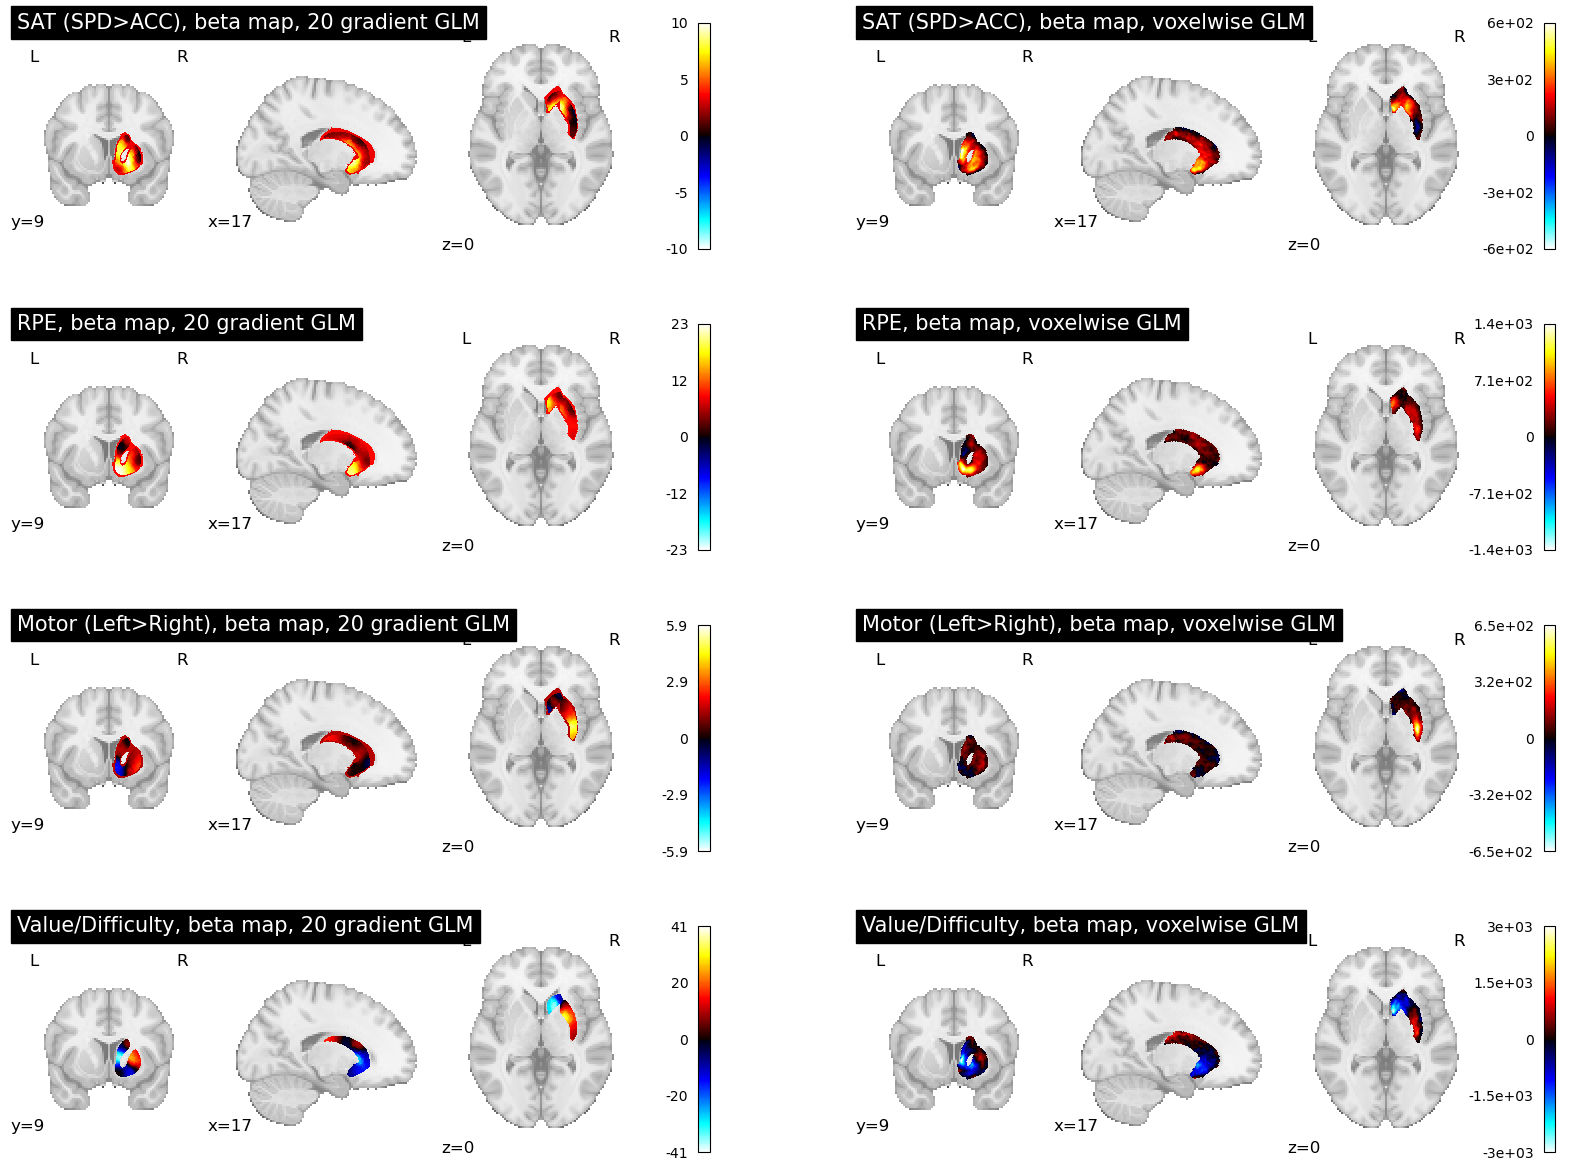

In [121]:
f, ax = plt.subplots(4,2, figsize=(20,15))

for i, contrast_info in enumerate(contrasts):
    dim_ = contrast_info[0]
    title_ = contrast_info[1]
    # mean_beta_voxelwise = nib.load(f'../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-dm/firstlevelcontrast-{contrast_info[2]}_secondlevelcontrast-intercept.nii.gz')
    mean_beta_voxelwise = nib.load(f'../derivatives/glm_feat/group_level_model/ses-rlsat/model-1-dm/model-1-dm_fwhm-1p5_subjectlevelcontrast-{contrast_info[3]}_grouplevelcontrast-1_flame-1_desc-cope.nii.gz')
    mean_beta_voxelwise_masked = image.math_img('nii*mask', nii=mean_beta_voxelwise, mask=mask_mni09c)

#    plotting.plot_stat_map(image.index_img(beta_map_mni, dim_), cut_coords=[17,9,0], draw_cross=False, axes=ax[i,0], title=f'{title_}, beta map, 20 gradient GLM')
    plotting.plot_stat_map(image.index_img(beta_map_mni_thresholded, dim_), cut_coords=[17,9,0], draw_cross=False, axes=ax[i,0], title=f'{title_}, beta map, 20 gradient GLM')
    plotting.plot_stat_map(mean_beta_voxelwise_masked, cut_coords=[17,9,0], draw_cross=False, axes=ax[i,1], title=f'{title_}, beta map, voxelwise GLM')

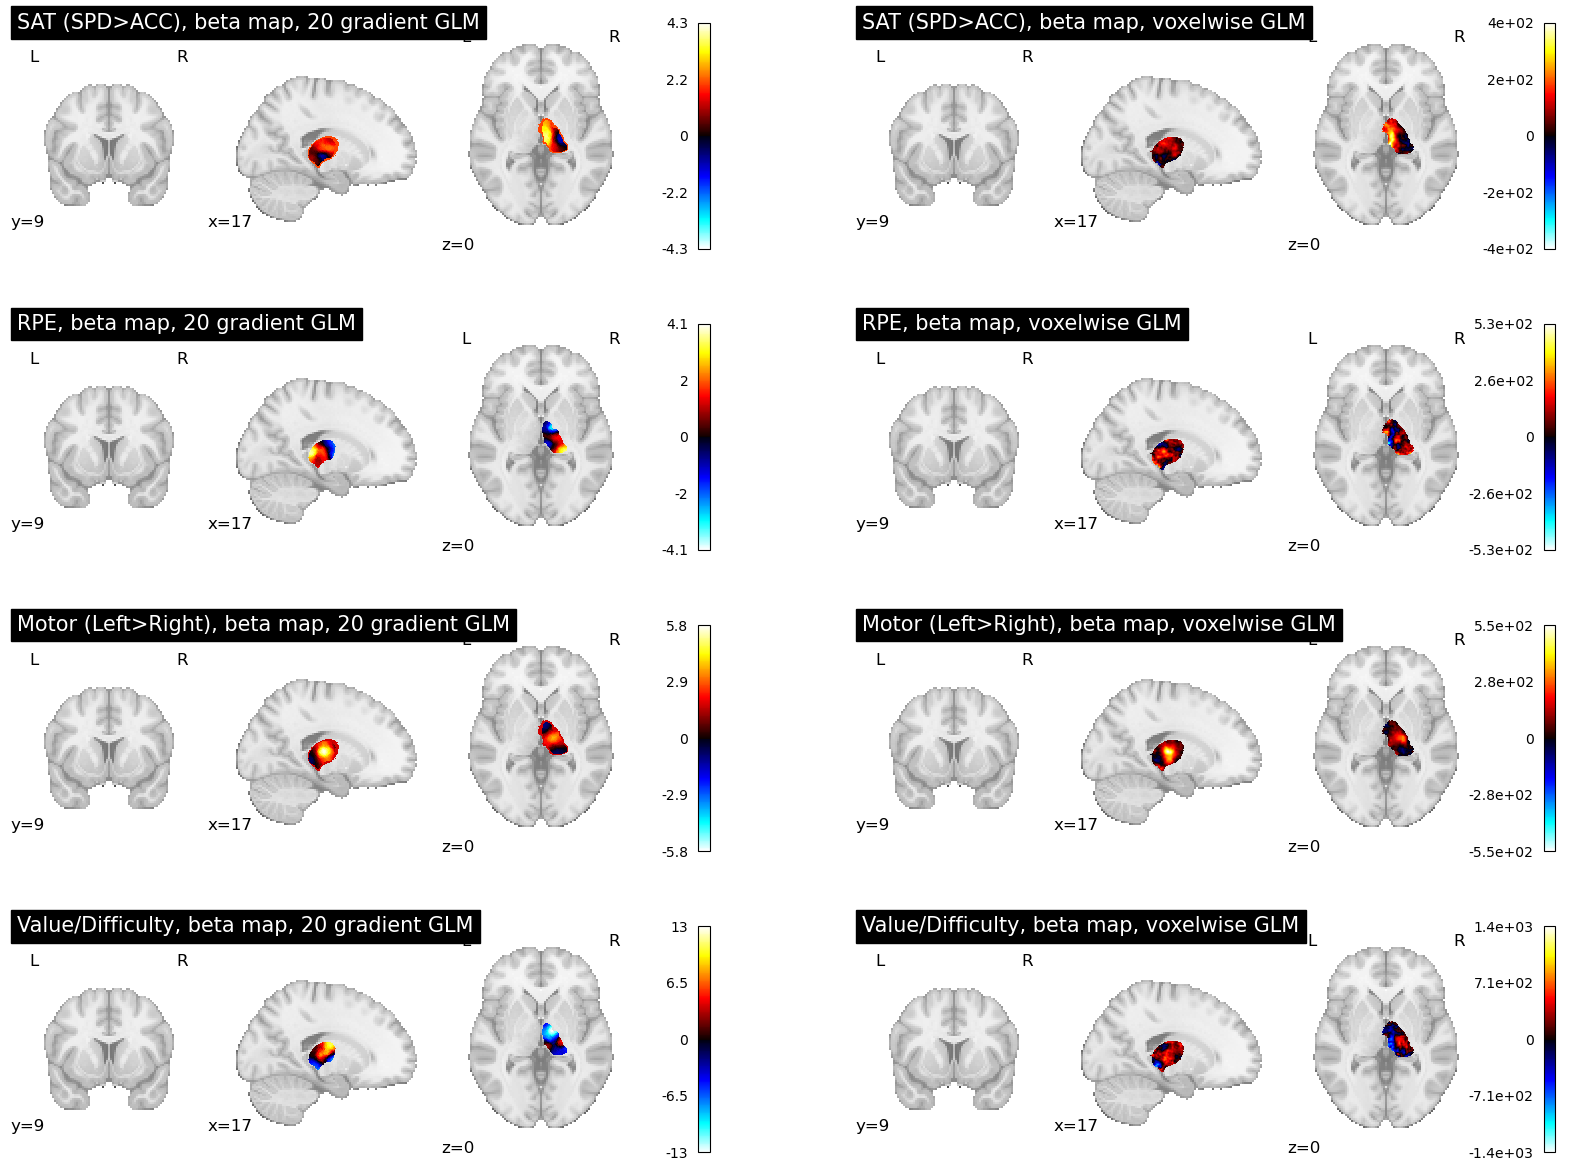

In [160]:
f, ax = plt.subplots(4,2, figsize=(20,15))

for i, contrast_info in enumerate(contrasts):
    dim_ = contrast_info[0]
    title_ = contrast_info[1]
    # mean_beta_voxelwise = nib.load(f'../derivatives/glm_nilearn/group_level_model/ses-rlsat/fwhm-1p5/model-1-dm/firstlevelcontrast-{contrast_info[2]}_secondlevelcontrast-intercept.nii.gz')
    mean_beta_voxelwise = nib.load(f'../derivatives/glm_feat/group_level_model/ses-rlsat/model-1-dm/model-1-dm_fwhm-1p5_subjectlevelcontrast-{contrast_info[3]}_grouplevelcontrast-1_flame-1_desc-cope.nii.gz')
    mean_beta_voxelwise_masked = image.math_img('nii*mask', nii=mean_beta_voxelwise, mask=mask_mni09c)

#    plotting.plot_stat_map(image.index_img(beta_map_mni, dim_), cut_coords=[17,9,0], draw_cross=False, axes=ax[i,0], title=f'{title_}, beta map, 20 gradient GLM')
    plotting.plot_stat_map(image.index_img(beta_map_mni_thresholded, dim_), cut_coords=[17,9,0], draw_cross=False, axes=ax[i,0], title=f'{title_}, beta map, 20 gradient GLM')
    plotting.plot_stat_map(mean_beta_voxelwise_masked, cut_coords=[17,9,0], draw_cross=False, axes=ax[i,1], title=f'{title_}, beta map, voxelwise GLM')

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


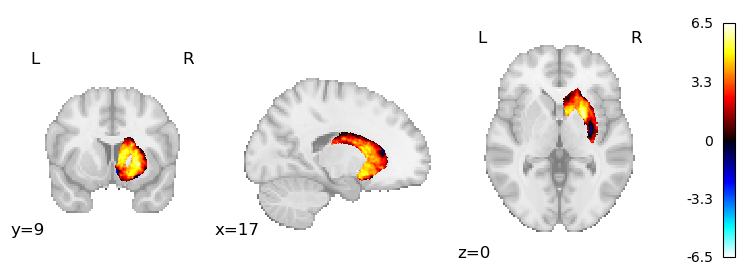

In [61]:
masker

NiftiLabelsMasker(labels_img=<nibabel.nifti1.Nifti1Image object at 0x7f168881f1c0>)

In [186]:
# gradients in T1w-space
hemisphere = 'l'
subject = '002'
all_gradients = sorted(glob.glob(f'../derivatives/masks_spectral_embeddings/sub-{subject}/anat/sub-{subject}_space-T1w_desc-mask-str-{hemisphere}_dim-*.nii.gz'))
# all_gradients = image.concat_imgs(all_gradients)

# Striatum mask in T1w space
subj_mask = nib.load(f'../derivatives/masks_massp_func/sub-{subject}/anat/sub-{subject}_space-T1w_desc-mask-Str-{hemisphere}.nii.gz')
subj_mask_bin = image.math_img('nii>.01', nii=subj_mask)

# mask out all zero voxels
# add binary mask as intercept 'gradient'
all_gradients.insert(0,subj_mask_bin)
all_gradients = image.concat_imgs(all_gradients)
gradients_data = all_gradients.get_fdata()
gradients_data[subj_mask.get_fdata()<0.01] = np.nan
all_gradients = nib.Nifti1Image(gradients_data, header=all_gradients.header, affine=all_gradients.affine)

# create voxel map
mask_data = subj_mask_bin.get_fdata()
mask_data[mask_data==True] = np.arange(mask_data.sum())
subj_mask_numbered = nib.Nifti1Image(mask_data, header=subj_mask.header, affine=subj_mask.affine)

In [58]:
# plotting.plot_stat_map(image.index_img(all_gradients, 3), bg_img=None)

In [189]:
masker = maskers.NiftiLabelsMasker(labels_img=subj_mask_numbered)
G = masker.fit_transform(all_gradients)

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


In [190]:
## Signal matrix y
epi_fns = sorted(glob.glob(f'../derivatives/susan_smoothed_func/sub-{subject}/ses-rlsat/func/sub-{subject}_ses-rlsat_task-rlsat_run-*_space-T1w_desc-preproc_bold_smoothed_fwhm-1p5.nii.gz'))
timeseries = [masker.fit_transform(x) for x in epi_fns]

In [195]:
timeseries_psc = [x/x.mean(0)*100-100 for x in timeseries]

In [197]:
# timeseries_psc[0].shape

(754, 3797)

In [200]:
#timeseries[0].shape
## z-score timeseries per run

y = np.vstack(timeseries_psc)

In [201]:
## design matrix X. For simplicity load from nilearn GLM's object
flm = load_first_level_model(f'../derivatives/glm_nilearn/subject_level_model/sub-{subject}/ses-rlsat/func/fwhm-1p5/model-1-dm/sub-{subject}_ses-rlsat_task-rlsat_space-T1w_desc-first-level-model.pkl')
X = flm.design_matrices_
X = np.vstack(X)
X.shape

(2262, 59)

## we got all ingredients now: X, y, G. Fit OLS

In [202]:
# some transposing
y = y.T  # y = n_voxels, n_timepoints
G = G.T  # G = n_voxels, n_gradients
X = X.T  # X = n_contrasts, n_timepoints

In [203]:
Ginv = np.linalg.pinv(G)

In [205]:
y_adj = Ginv@y

/tmp/ipykernel_3574022/1554680716.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(X, y_adj.T)


(array([[ 8.65799593e-01, -1.11660860e+03,  1.49587394e+02, ...,
         -1.34714622e+02, -1.28227412e+02,  5.43896394e+02],
        [ 1.90062872e+00,  8.56619215e+01, -1.13361707e+03, ...,
          1.49863760e+02, -1.31455842e+02, -2.24639087e+02],
        [ 2.68156280e+00,  3.43281880e+02,  8.99532362e+01, ...,
          1.93510892e+02,  6.05101392e+02, -8.12226024e+02],
        ...,
        [ 6.83988376e-01, -1.10892656e+02,  3.57945998e+01, ...,
         -2.35642730e+01, -5.33670759e+01,  5.03184892e+01],
        [-3.52490596e-01,  3.32952283e+01, -3.92638369e+01, ...,
          3.06421902e+01, -4.95722496e+01, -2.18111536e+01],
        [-2.96886364e-02, -1.08191834e+02,  1.52301258e+02, ...,
          2.11923901e+01,  6.17158807e+00, -5.57094956e+01]]),
 array([2.72792906e+02, 1.76316442e+07, 1.17451771e+07, 1.66411567e+06,
        1.84159317e+06, 3.43912132e+06, 4.67724973e+06, 1.57895403e+06,
        5.39587877e+06, 2.42156571e+06, 1.70075123e+06, 3.26191925e+06,
        1.606

In [158]:
# ## OLS
# gamma = np.linalg.lstsq(X, y_adj.T)

In [206]:
xtxtt = np.linalg.pinv(X.T@X) @ X.T #@ y[0,:]

In [207]:
xtxtt.shape

(2262, 59)

In [208]:
y_adj.T.shape

(2262, 21)

In [209]:
gamma = xtxtt.T@y_adj.T

In [210]:
gamma.shape

(59, 21)

In [211]:
G.shape

(3797, 21)

In [213]:
beta = G@gamma.T

In [214]:
beta.shape

(3797, 59)

In [216]:
beta_nii = masker.inverse_transform(beta.T)

In [217]:
beta_nii.shape

(92, 118, 95, 59)

In [218]:
bg_img = '../derivatives/fmriprep/fmriprep/sub-002/anat/sub-002_desc-preproc_T1w.nii.gz'

In [ ]:
plotting.plot_stat_map(image.index_img(beta_nii,0), cut_coords=[-5,0,5,10,15,20,23], display_mode='z', bg_img=bg_img, title='SPD>ACC')
plotting.plot_stat_map(image.index_img(beta_nii,4), cut_coords=[-5,0,5,10,15,20,23], display_mode='z', bg_img=bg_img, title='Prediction error')
plotting.plot_stat_map(image.index_img(beta_nii,6), cut_coords=[-5,0,5,10,15,20,23], display_mode='z', bg_img=bg_img, title='Left>Right')
plotting.plot_stat_map(image.index_img(beta_nii,8), cut_coords=[-5,0,5,10,15,20,23], display_mode='z', bg_img=bg_img, title='Value difference')

## Compare to actual beta maps from Nilearn

In [ ]:
contrast1 = '../derivatives/glm_nilearn/subject_level_model/sub-002/ses-rlsat/func/fwhm-1p5/model-1-dm/sub-002_ses-rlsat_task-rlsat_space-T1w_desc-contrast-spdminacc_effect_size.nii.gz'
contrast2 = '../derivatives/glm_nilearn/subject_level_model/sub-002/ses-rlsat/func/fwhm-1p5/model-1-dm/sub-002_ses-rlsat_task-rlsat_space-T1w_desc-contrast-RPE_effect_size.nii.gz'
contrast3 = '../derivatives/glm_nilearn/subject_level_model/sub-002/ses-rlsat/func/fwhm-1p5/model-1-dm/sub-002_ses-rlsat_task-rlsat_space-T1w_desc-contrast-leftminright_effect_size.nii.gz'
contrast4 = '../derivatives/glm_nilearn/subject_level_model/sub-002/ses-rlsat/func/fwhm-1p5/model-1-dm/sub-002_ses-rlsat_task-rlsat_space-T1w_desc-contrast-stimulus_value_diff_effect_size.nii.gz'

## mask these
contrast1 = image.math_img('nii*mask', nii=contrast1, mask=subj_mask_bin)
contrast2 = image.math_img('nii*mask', nii=contrast2, mask=subj_mask_bin)
contrast3 = image.math_img('nii*mask', nii=contrast3, mask=subj_mask_bin)
contrast4 = image.math_img('nii*mask', nii=contrast4, mask=subj_mask_bin)

In [ ]:
plotting.plot_stat_map(contrast1, cut_coords=[-5,0,5,10,15,20,23], display_mode='z', bg_img=bg_img, title='SPD>ACC')
plotting.plot_stat_map(contrast2, cut_coords=[-5,0,5,10,15,20,23], display_mode='z', bg_img=bg_img, title='Prediction error')
plotting.plot_stat_map(contrast3, cut_coords=[-5,0,5,10,15,20,23], display_mode='z', bg_img=bg_img, title='Left>Right')
plotting.plot_stat_map(contrast4, cut_coords=[-5,0,5,10,15,20,23], display_mode='z', bg_img=bg_img, title='Value difference')

In [181]:
3797*5

18985

## What the f is going wrong with subject 44?

In [68]:
fsl_firstlevel_cope = nib.load('../processing/nipype_workflow_folders/feat_level3_rlsat/_contrast_n_3_fwhm_1p5_model_n_1-z/copemerge/sub-002_ses-rlsat_task-rlsat_space-MNI152NLin2009cAsym_model-1-z_contrast-3_desc-cope_merged.nii.gz')
fsl_firstlevel_cope.shape

(193, 229, 193, 37)

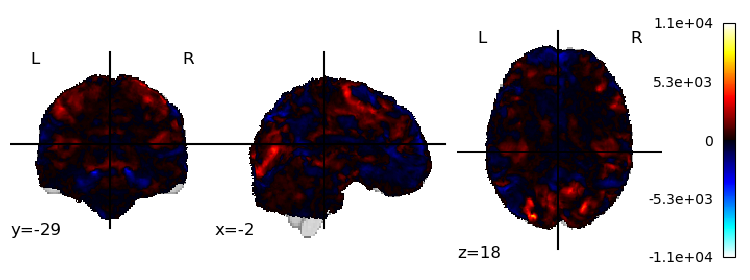

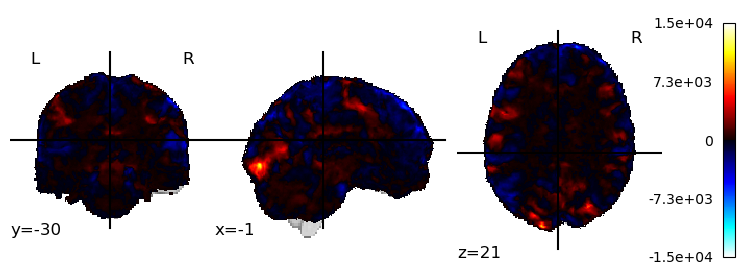

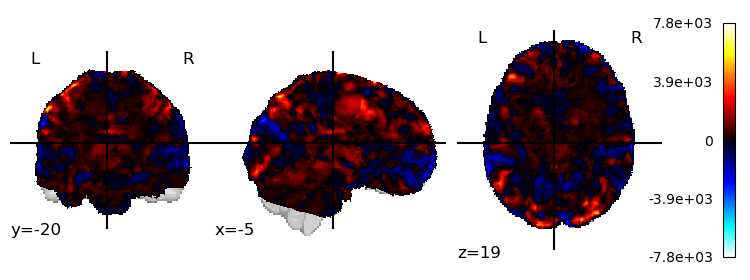

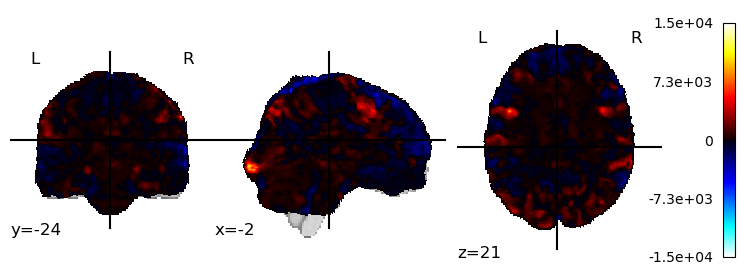

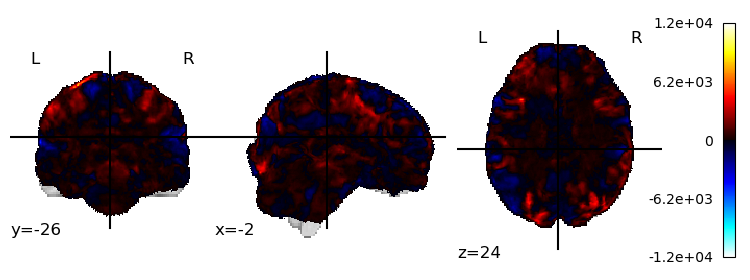

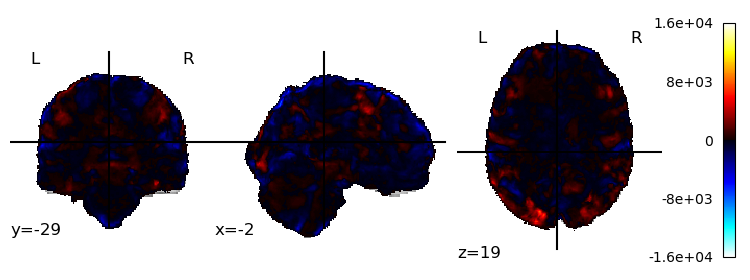

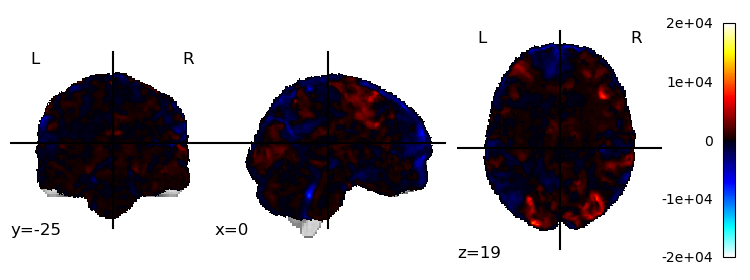

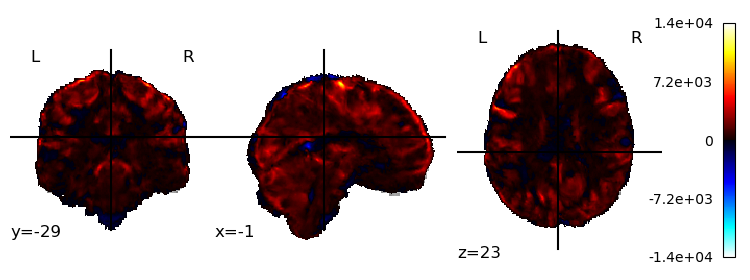

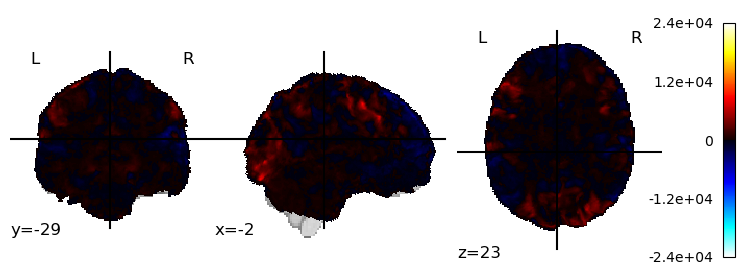

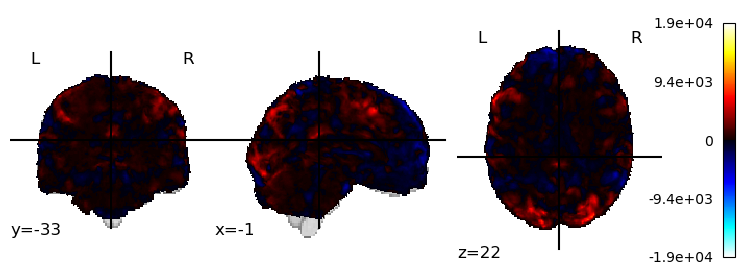

In [64]:
for i in range(10):
    plotting.plot_stat_map(image.index_img(fsl_firstlevel_cope, i))

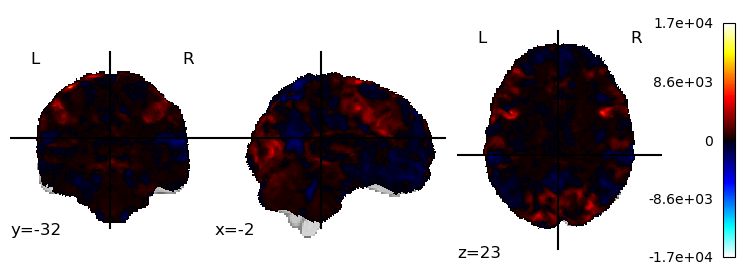

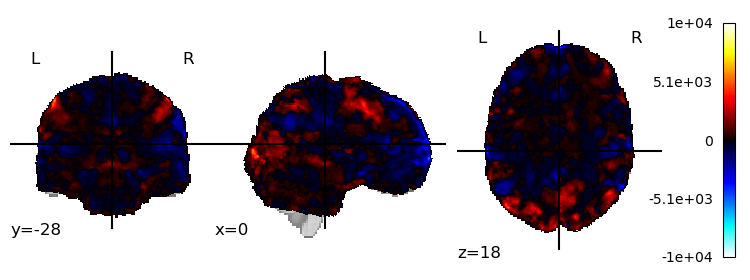

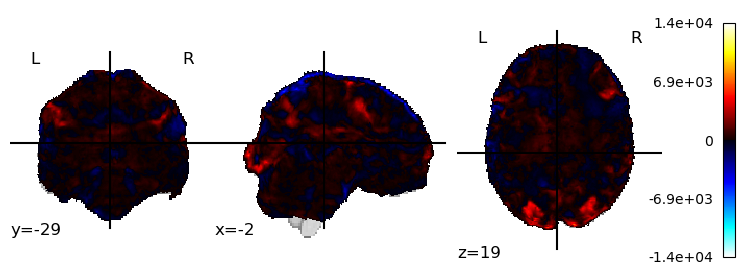

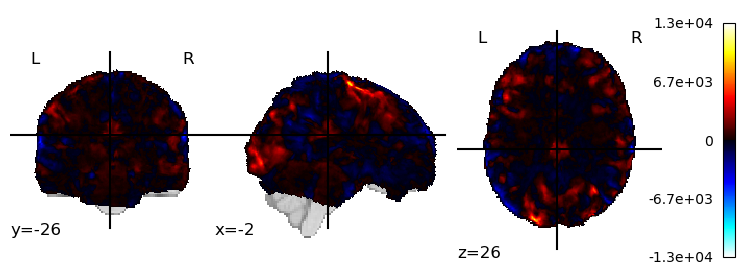

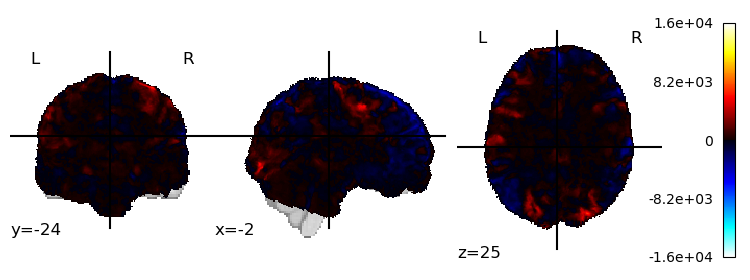

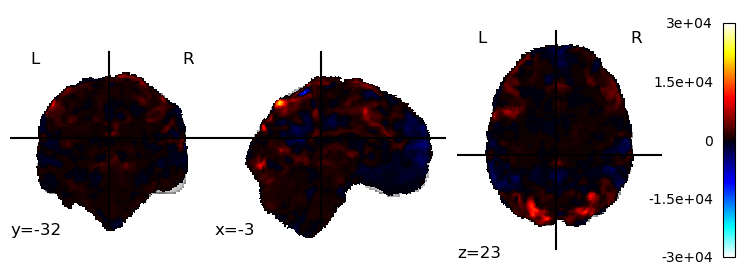

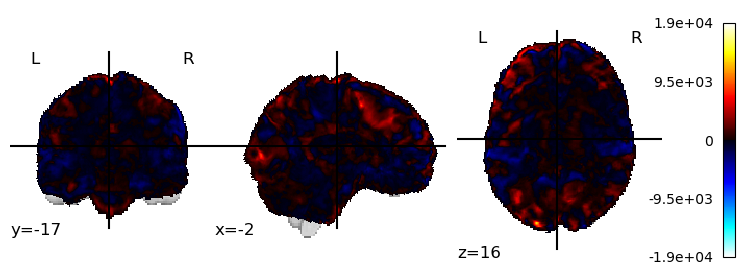

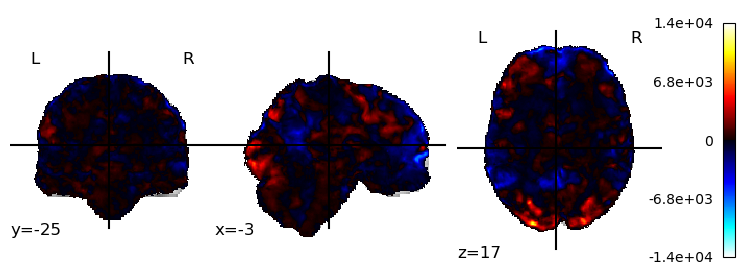

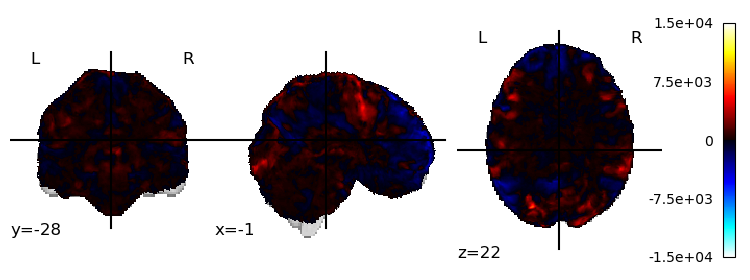

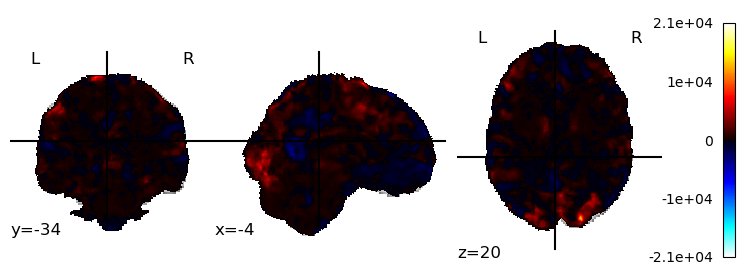

In [65]:
for i in range(10, 20):
    plotting.plot_stat_map(image.index_img(fsl_firstlevel_cope, i))

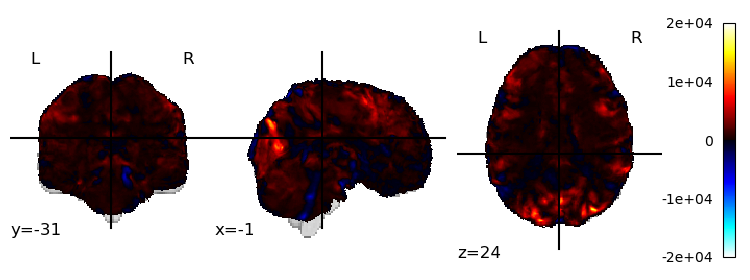

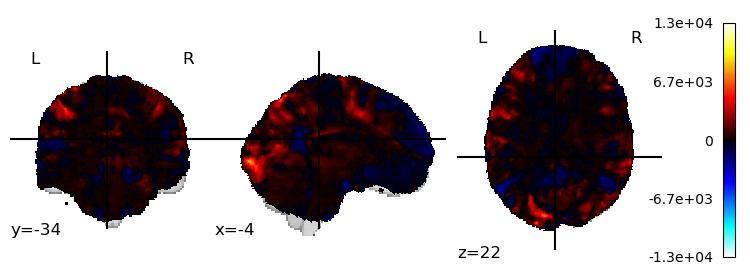

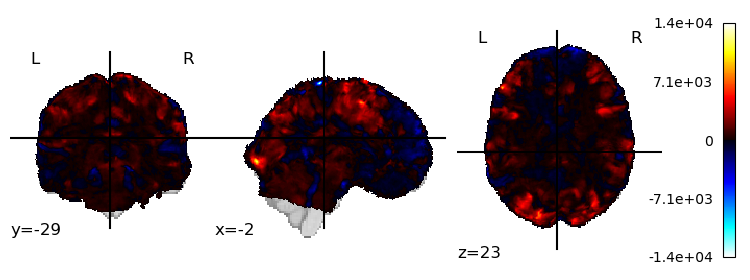

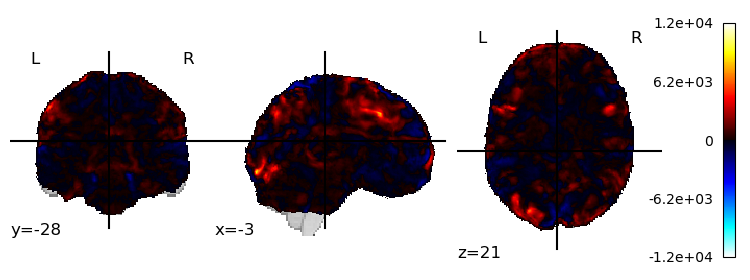

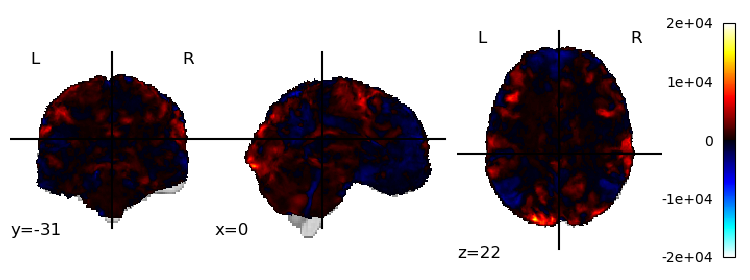

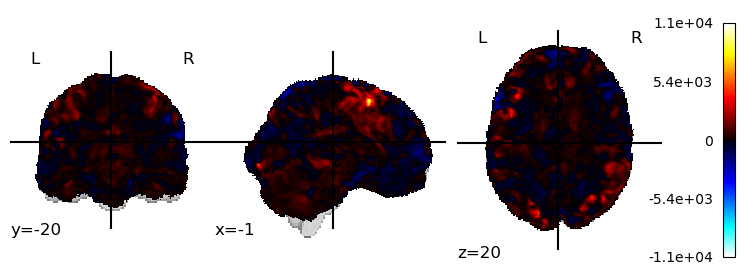

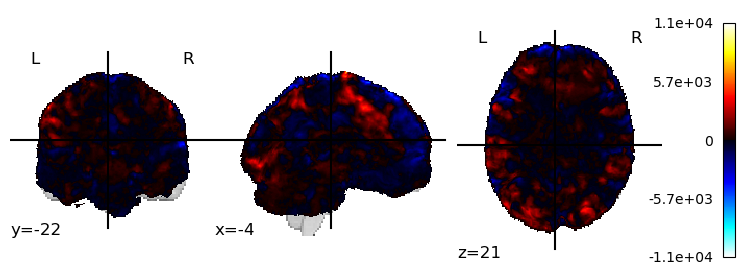

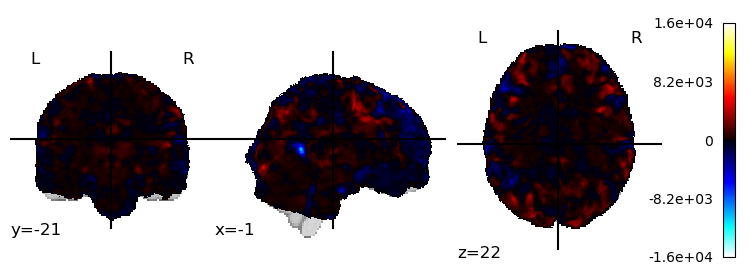

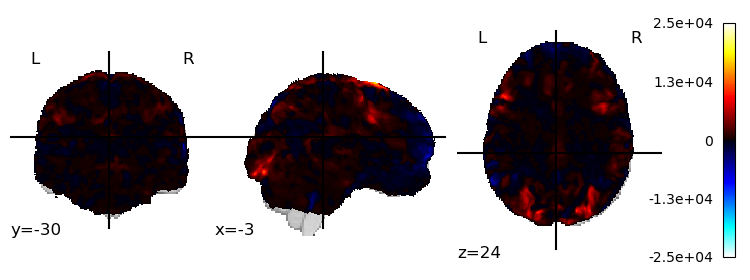

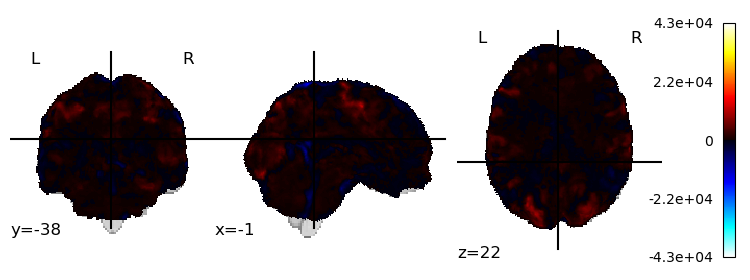

In [66]:
for i in range(20, 30):
    plotting.plot_stat_map(image.index_img(fsl_firstlevel_cope, i))

IndexError: index 37 is out of bounds for axis 3 with size 37

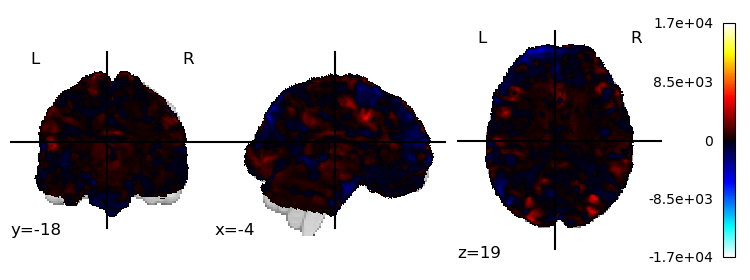

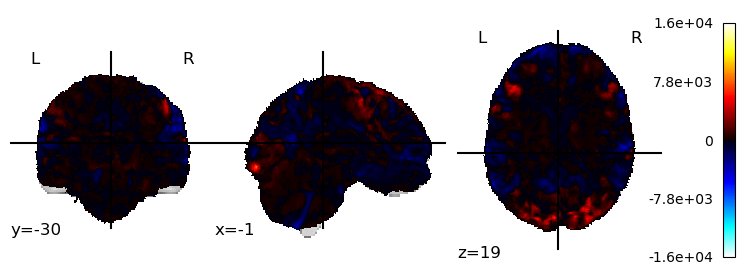

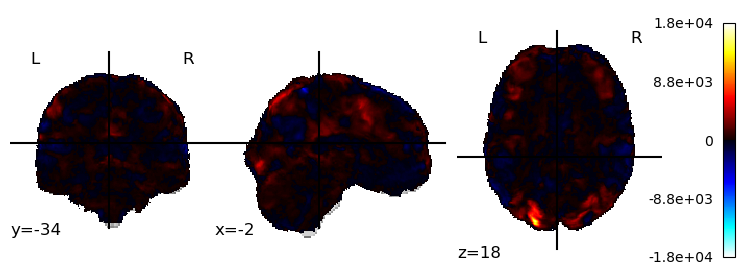

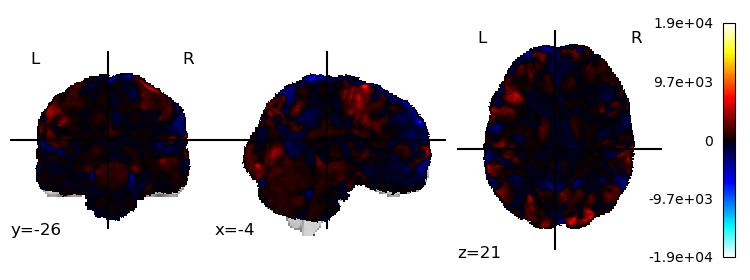

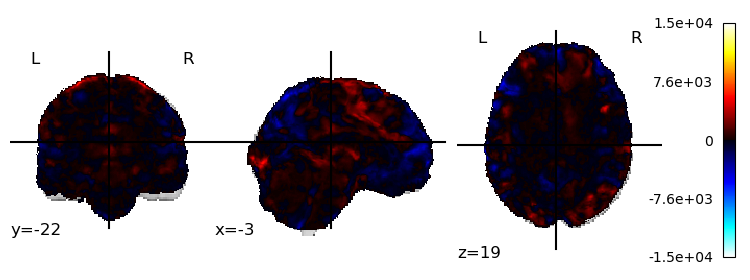

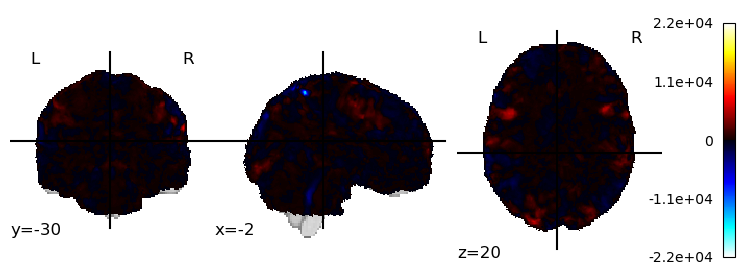

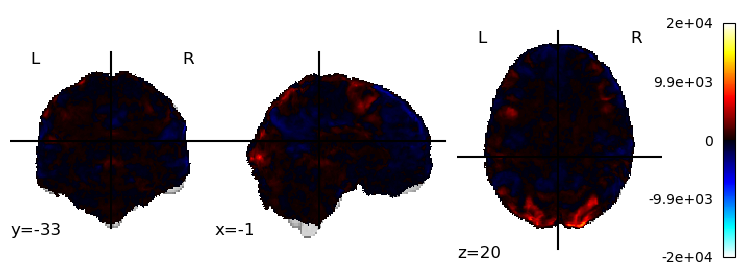

In [67]:
for i in range(30, 40):
    plotting.plot_stat_map(image.index_img(fsl_firstlevel_cope, i))

In [69]:
fsl_firstlevel_varcope = nib.load('../processing/nipype_workflow_folders/feat_level3_rlsat/_contrast_n_3_fwhm_1p5_model_n_1-z/varcopemerge/sub-002_ses-rlsat_task-rlsat_space-MNI152NLin2009cAsym_model-1-z_contrast-3_desc-varcope_merged.nii.gz')
fsl_firstlevel_varcope.shape

(193, 229, 193, 37)

IndexError: index 37 is out of bounds for axis 3 with size 37

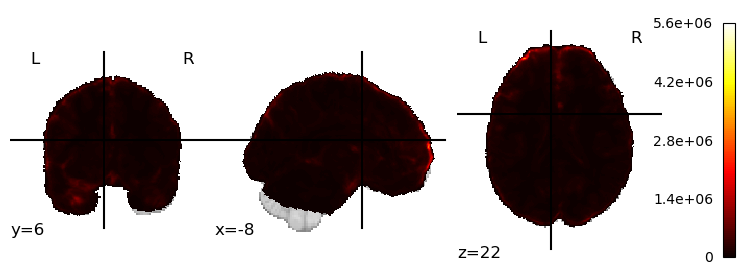

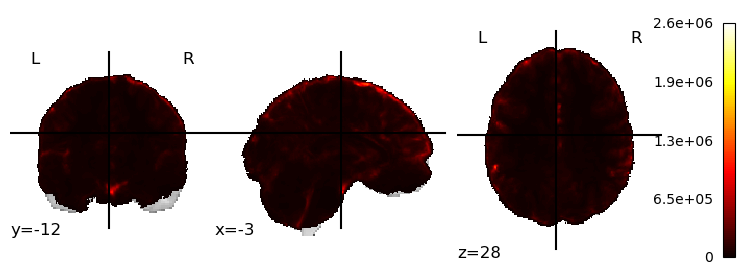

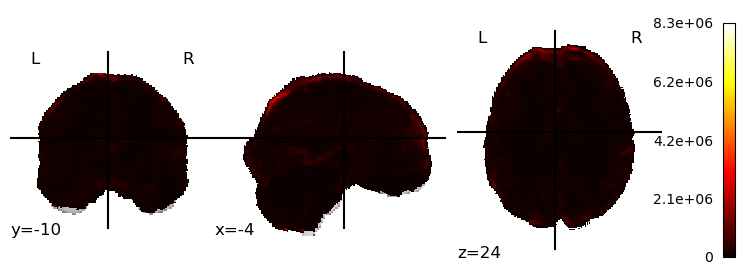

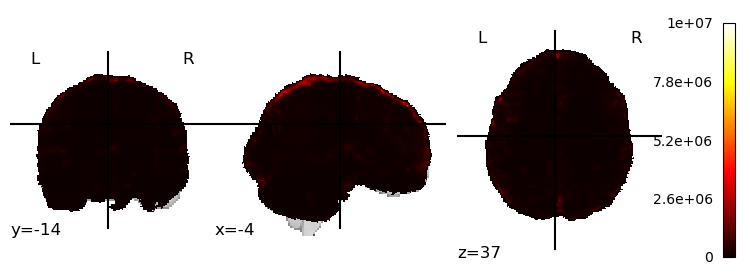

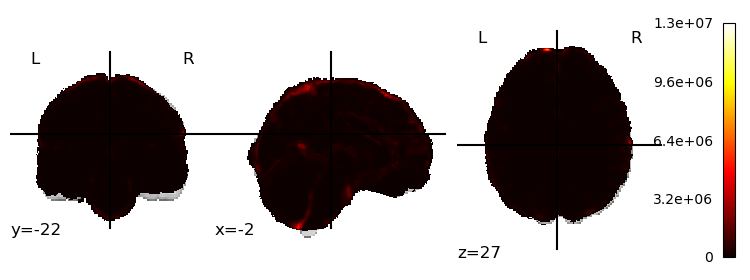

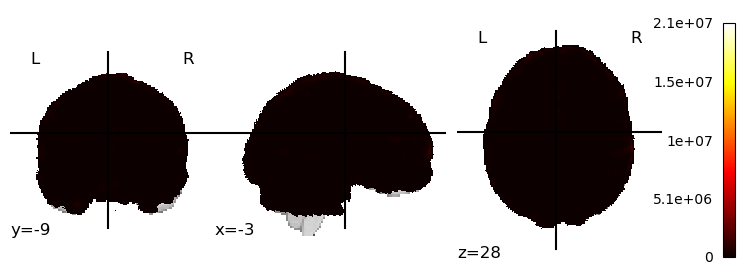

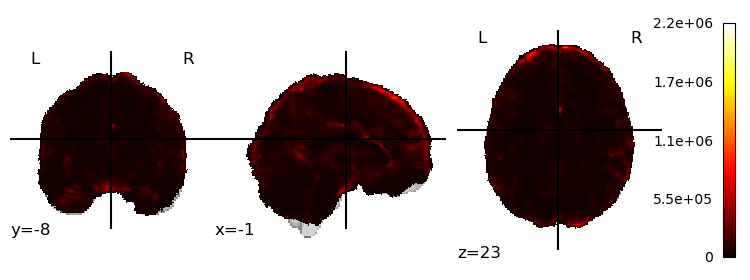

In [70]:
for i in range(30, 40):
    plotting.plot_stat_map(image.index_img(fsl_firstlevel_varcope, i))

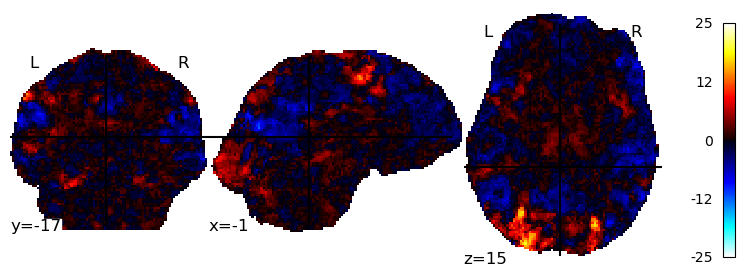

In [72]:
zmap = nib.load('~/Projects/trondheim/processing/nipype_workflow_folders/feat_level12_rlsat/_model_n_1-z_smoothing_fwhm_1p5_space_T1w_subject_id_044/flameo/mapflow/_flameo3/stats/zstat1.nii.gz')
plotting.plot_stat_map(zmap, bg_img=None)

In [74]:
fsl_firstlevel_cope.shape

(193, 229, 193, 37)

In [77]:
ranges = np.ptp(fsl_firstlevel_cope.get_fdata(), axis=-1)

In [79]:
ranges.shape

(193, 229, 193)

In [82]:
ranges_nii = image.math_img('np.ptp(nii, axis=-1)', nii=fsl_firstlevel_cope)

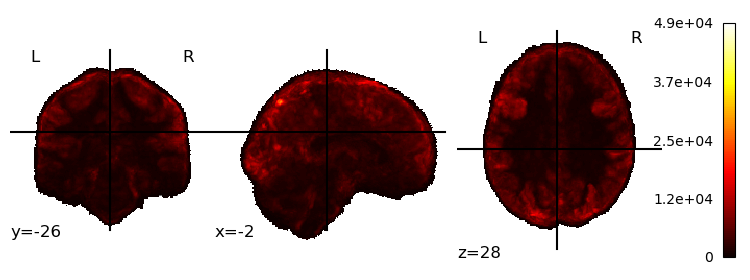

In [83]:
plotting.plot_stat_map(ranges_nii)